In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time


# Load Input Data:

In [3]:
vot_pdf = np.genfromtxt('../original_code/VOT_distr.csv', delimiter=',')[1:]
vots = []
vot_p = []
for row in vot_pdf:
    vots.append(row[0])
    vot_p.append(row[1])
print(vot_p)
print()
vot_p=vot_p/np.sum(vot_p)
print(vot_p)

[0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.04, 0.02, 0.07, 0.02, 0.07, 0.16, 0.13, 0.05, 0.25, 0.03, 0.05]

[0.00990099 0.01980198 0.00990099 0.01980198 0.01980198 0.01980198
 0.01980198 0.03960396 0.01980198 0.06930693 0.01980198 0.06930693
 0.15841584 0.12871287 0.04950495 0.24752475 0.02970297 0.04950495]


# Travel time functions:

In [4]:
###### BPR Parameters ###### 
bpr_true_capacity = 66
bpr_true_fftt = 60*22/67
bpr_true_alpha = 0.2

def true_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, alpha = bpr_true_alpha):
    """
    Find the (exact) travel time on an edge given an edge flow
    """

    return fftt * (1+alpha*(flow_val/capacity)**6)

###### Approximation Parameters ###### 
const_multiplier = 1
cap_thresh_multiplier = 0.7835
apx_slope = 0.314

def apx_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, 
                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b = apx_slope):
    """
    Find the (approximate) travel time on an edge given an edge flow
    """
    
    if flow_val <= cap_thresh*capacity:
        return a*fftt
    else:
        return a*fftt + b*(flow_val - cap_thresh*capacity)

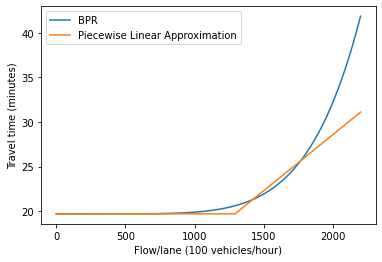

In [5]:
###### Check plots of BPR and approximation ###### 
multiplier = 100/4 # converts from 100 vehicles/hour --> vehicle/hour per lane

x =  np.linspace(0,int(np.round(88*multiplier,0)),int(np.round(89*2*multiplier,0)))
y = [true_bpr_cost(i, capacity = bpr_true_capacity*multiplier) for i in x]

plt.plot(x, y,label='BPR')

y_apx = [apx_bpr_cost(i,capacity = bpr_true_capacity*multiplier, b = apx_slope/multiplier) for i in x]

plt.plot(x, y_apx,label='Piecewise Linear Approximation')
plt.xlabel("Flow/lane (100 vehicles/hour)")
plt.ylabel("Travel time (minutes)")
plt.legend(loc='upper left')

# Generate Demand Profile:

In [6]:
###### Specify parameters for problem ###### 
T = 5 # Time Horizon
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
print('Tau:\n {}'.format(tau_arr))
print()

B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
print('B:\n {}'.format(B_arr))
print()

num_total = 8000 # number of users
num_eligible =int( num_total*.17) # number of eligible users
num_ineligible = num_total-num_eligible # number of ineligible users

###### VoT information ###### 
vot_all = np.sort(np.round(np.random.choice(vots, size = num_total, p=vot_p),2)/60) # generate baseline VoT for all users
vot_all_days = np.empty(shape=(num_total,T)) 
count=0
for v in vot_all:
    if count < num_eligible:
        vot_all_days[count,:]=[v for t in range(T)] # VoT of eligible users does not vary over time periods
    else:
        vot_all_days[count,:]=list((1+0.25*(np.random.random_sample(size=T)-0.5))*v) # VoT of ineligible users varies over time periods
    count+=1
    
vot_eligible = vot_all_days[:num_eligible,:]
vot_ineligible= vot_all_days[num_eligible:,:]

print('Eligible vot range:\n {} ({} $/hr), {} ({} $/hr)'.format(np.min(vot_eligible),60*np.min(np.round(vot_eligible,2)),np.max(np.round(vot_eligible,2)),60*np.max(np.round(vot_eligible,2))))
print()
print('Ineligible vot range:\n {}({} $/hr), {} ({} $/hr)'.format(np.min(np.round(vot_ineligible,2)),60*np.min(np.round(vot_ineligible,2)),np.max(np.round(vot_ineligible,2)),60*np.max(np.round(vot_ineligible,2))))
print()
print('Mean vot:\n {} $/hr; median: {} $/hr'.format(60*np.round(np.mean(vot_all_days),2),60*np.round(np.median(vot_all_days),2)))

Tau:
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

B:
 [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]

Eligible vot range:
 0.02 (1.2 $/hr), 0.24 (14.399999999999999 $/hr)

Ineligible vot range:
 0.21(12.6 $/hr), 2.7 (162.0 $/hr)

Mean vot:
 43.8 $/hr; median: 33.6 $/hr


Text(0, 0.5, '% of population')

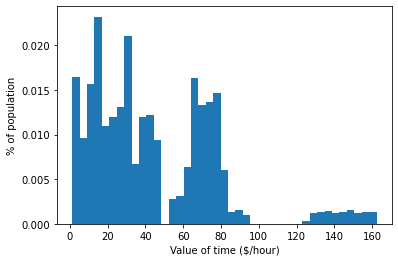

In [7]:
###### Check VoT distribution ###### 
plt.hist(vot_all_days.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

# Define Social Objectives of Interest:

In [8]:
###### Estimate VoT percentiles for ineligible group ###### 
percentiles = {}
thresh = 10
for p in range(11):
    print(np.round(np.percentile(vot_ineligible,p*10)*60,2))
    percentiles[p*10]=np.percentile(vot_ineligible,p*10)

12.62
16.77
23.03
29.73
33.61
43.18
62.39
68.07
74.26
79.97
162.26


# Solver 2, Discount:

In [9]:
# Solver 2, Discount:

def OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity, c_2 = bpr_true_capacity, 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope, b_2 = apx_slope):
    """
    Function to solve convex optimization problem given a particular toll and budget value
    """
    
    # Initialize model
    m1 = gp.Model()
    # Add variables to model
#     users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = 0.0, ub = 2.0)
#     edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = 0.0, ub = num_ineligible * 2.0)
#     users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = 0.0, ub = 2.0)
    # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    
#     # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    users_in = m1.addVars(num_ineligible, 2, T, name = 'ineligible_val', lb = -10000.0, ub = 10000.0)
    edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = -10000.0, ub = 10000.0)
    users_el = m1.addVars(2, T, name = 'eligible_allocation', lb = -10000.0, ub = 10000.0)
    eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = -10000.0, ub = 10000.0)   

    ## Add constraints to Model 
    
    # Total edge flow, express and general purpose lanes:
    m1.addConstrs((edge_flows[j, t] == sum(users_in[i, j, t] for i in range(num_ineligible)) + \
                  users_el[j, t] for j in range(2) for t in range(T)))
    
    # Non-negativity of flows, and zero flow for "eligible users in ineligible groups":
    m1.addConstrs((users_in[i, j, t]>=0 for i in range(num_ineligible) for j in range(2) for t in range(T)))
    m1.addConstrs((users_el[j, t]>=0 for j in range(2) for t in range(T)))
    
    # Every eligible and ineligible user is assigned to one of three options: \
    # (express paying, express with credit, non-express)
    m1.addConstrs((sum(users_in[i, j, t] for j in range(2)) == 1 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((sum(users_el[j, t] for j in range(2)) == num_eligible for t in range(T)))
        
    # Piecewise affine approximation:
    m1.addConstrs((eps_flows[j, t] >= 0 for j in range(2) for t in range(T))) # Must be at least 0
    m1.addConstrs((eps_flows[0, t] >= edge_flows[0, t] - cap_thresh*c_1 for t in range(T))) # Must be at least flow - capacity
    m1.addConstrs((eps_flows[1, t] >= edge_flows[1, t] - cap_thresh*c_2 for t in range(T))) # Must be at least flow - capacity
    
    
    ## To edit below:
    # Set Objective
    m1.setObjective(sum( a*fftt_1*(edge_flows[0, t]) + b_1*(eps_flows[0, t]**2)/2  
                        + a*fftt_2*(edge_flows[1, t]) + b_2*(eps_flows[1, t]**2)/2 
                        + sum( toll*users_in[i,0,t]/vot_ineligible[i,t] for i in range(num_ineligible))
                        + sum( (1 - discount_ratio)*toll*users_el[0,t]/vot_eligible[i,t] for i in range(num_eligible))
        for t in range(T)), GRB.MINIMIZE)
    
    m1.update()
    
    return m1

In [10]:
def _extract_solution_discount(m, num_ineligible = num_ineligible):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    eps_flows = [v.x for v in m.getVars() if v.VarName.find("eps_flows") != -1]
    
    users_in = np.reshape(users_in, (num_ineligible, 2, T))
    users_el = np.reshape(users_el, (2, T))
    edge_flows = np.reshape(edge_flows, (2, T))
    eps_flows = np.reshape(eps_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows,
        "eps_flows": eps_flows
    }
    return solution

In [11]:
def to_str(num):
    num = int(num)
    
    # For any number < 100:
    if num < 10:
        return str(0) + str(num)
    else:
        return str(num)

# Solve Optimization Problem for Discretized Grid:

## Case 2 - Discount:

In [12]:
# tau_arr = 20 * np.linspace(0, 1, 21)[0:] # Toll discretization
# B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
# print(tau_arr)
# print()
# print(B_arr)
# print()

In [13]:
t_1 = time.time()

demand_multiplier = [25,75]

# For saving data:
path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data_discount/"

row_names = ["Edge flows", "Eps flows", "Eligible User Flows"]
row_names += ["Ineligible User Flow, " + str(k) for k in list(range(num_ineligible + 1))[1:]]

column_names = []
workday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
lane_names = ["Express", "General Purpose"]
for workday_index, workday in enumerate(workday_names):
    for lane_index, lane in enumerate(lane_names):
        column_names.append(workday + ", " + lane)

## Toll and budget lists:
tau_arr = 20 * np.linspace(0, 1, 21)[0:] # Toll discretization
B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 

## For debugging purposes, truncate tau_arr and B_arr:
# tau_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# B_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# tau_arr = [20]
# tau_arr = 20 * np.linspace(0, 1, 11)[0:] 
# B_arr = np.linspace(0, tau_arr[-1]*4, 9)
# tau_arr = [2.0]
# B_arr = [0.0]


total_count = len(tau_arr) * len(B_arr)

for toll_idx, toll in enumerate(tau_arr):
    for budget_idx, budget in enumerate(B_arr):
        
        discount_ratio = budget/(toll*T) if (toll != 0 and budget < toll*T) else 1
        print()
        print("Toll:", toll)
        print("Budget:", budget)
        print("Discount Ratio:", discount_ratio)
        print()
        
        m_discount = OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
                    vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
                      fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
                     a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

        m_discount.optimize()
        
        # Extract Solution:
        solution_set = _extract_solution_discount(m_discount)
        
        if toll == tau_arr[0]:
            print()
            print("Edge flows:", solution_set["edge_flows"])
            print()
            
        ### Frank - To modify below:
        # Storing data:
        data_edge_flows = solution_set["edge_flows"].T.reshape(10)
        data_eps_flow = solution_set["eps_flows"].T.reshape(10)
        data_users_el = solution_set["users_el"].T.reshape(10)
        data_users_in = solution_set["users_in"].transpose(0, 2, 1).reshape((num_ineligible, 5*2))
        data = np.vstack((data_edge_flows, data_eps_flow, data_users_el, data_users_in))
        
        file_name = path_directory + "toll_" + to_str(toll) + "_discount_" + to_str(budget) + ".csv"
        df = pd.DataFrame(data, columns = column_names, index = row_names)        
        df.to_csv(file_name)
        
                

t_2 = time.time()
print("Run time:", t_2 - t_1)


Toll: 0.0
Budget: 0.0
Discount Ratio: 1

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-03
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x4f369e61
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 66410 columns
Presolve time: 0.14s
Presolved: 15 rows, 20 columns, 30 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads   

  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 66410 columns
Presolve time: 0.12s
Presolved: 15 rows, 20 columns, 30 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.38120843e+06 -2.17735323e+07  3.98e+02 8.04e+02  1.33e+06     0s
   1   2.02148139e+06 -7.24030726e+06  2.27e-13 8.04e-04  1.85e+05     0s
   2   1.22672981e+06  3.60901377e+05  6.82e-13 1.35e-05  1.73e+04     0s
   3   8.86371925e+05  7.76264517e+05  1.59e-12 1.34e-11  2.20e+03     0s
   4   8.50996400e+05  8.48068733e+05  5.46e-12 5.68e-14  5.86e+01     0s
   5   8.50880829e+05  8.50866231e+05  1.16e-10 1.42e-14  2.92e-01     0s
   6   8.50880702e+05  8.50880687e+0

   2   1.22672981e+06  3.60901377e+05  6.82e-13 1.35e-05  1.73e+04     0s
   3   8.86371925e+05  7.76264517e+05  1.59e-12 1.34e-11  2.20e+03     0s
   4   8.50996400e+05  8.48068733e+05  5.46e-12 5.68e-14  5.86e+01     0s
   5   8.50880829e+05  8.50866231e+05  1.16e-10 1.42e-14  2.92e-01     0s
   6   8.50880702e+05  8.50880687e+05  2.52e-10 5.68e-14  2.92e-04     0s
   7   8.50880702e+05  8.50880702e+05  1.14e-10 0.00e+00  2.92e-07     0s
   8   8.50880702e+05  8.50880702e+05  8.61e-13 2.13e-14  2.92e-10     0s

Barrier solved model in 8 iterations and 0.17 seconds (0.11 work units)
Optimal objective 8.50880702e+05


Edge flows: [[2000. 2000. 2000. 2000. 2000.]
 [6000. 6000. 6000. 6000. 6000.]]


Toll: 0.0
Budget: 45.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 6



Edge flows: [[2000. 2000. 2000. 2000. 2000.]
 [6000. 6000. 6000. 6000. 6000.]]


Toll: 0.0
Budget: 65.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x4f369e61
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 66410 columns
Presolve time: 0.11s
Presolved: 15 rows, 20 columns, 30 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

  

  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 66410 columns
Presolve time: 0.11s
Presolved: 15 rows, 20 columns, 30 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.38120843e+06 -2.17735323e+07  3.98e+02 8.04e+02  1.33e+06     0s
   1   2.02148139e+06 -7.24030726e+06  2.27e-13 8.04e-04  1.85e+05     0s
   2   1.22672981e+06  3.60901377e+05  6.82e-13 1.35e-05  1.73e+04     0s
   3   8.86371925e+05  7.76264517e+05  1.59e-12 1.34e-11  2.20e+03     0s
   4   8.50996400e+05  8.48068733e+05  5.46e-12 5.68e-14  5.86e+01     0s
   5   8.50880829e+05  8.50866231e+05  1.16e-10 1.42e-14  2.92e-01     0s
   6   8.50880702e+05  8.50880687e+05  2.52e-10 5.68e-14  2.92e-04    

  14   8.52648595e+05  8.52313876e+05  2.67e-06 3.10e-10  5.04e-03     0s
  15   8.52605951e+05  8.52383102e+05  1.75e-06 2.03e-10  3.35e-03     0s
  16   8.52581277e+05  8.52421127e+05  1.08e-06 1.25e-10  2.41e-03     0s
  17   8.52560158e+05  8.52450783e+05  6.27e-07 7.26e-11  1.65e-03     0s
  18   8.52529650e+05  8.52490457e+05  1.65e-07 1.89e-11  5.90e-04     0s
  19   8.52519779e+05  8.52502171e+05  6.41e-08 7.29e-12  2.65e-04     0s
  20   8.52515173e+05  8.52507443e+05  2.56e-08 2.74e-12  1.16e-04     0s
  21   8.52513180e+05  8.52509659e+05  1.22e-08 1.21e-12  5.30e-05     0s
  22   8.52512533e+05  8.52510376e+05  6.68e-09 6.68e-13  3.25e-05     0s
  23   8.52511953e+05  8.52511013e+05  2.71e-09 2.27e-13  1.41e-05     0s
  24   8.52511647e+05  8.52511339e+05  6.31e-10 7.11e-14  4.63e-06     0s
  25   8.52511541e+05  8.52511451e+05  8.76e-10 5.68e-14  1.36e-06     0s
  26   8.52511498e+05  8.52511493e+05  4.53e-09 5.68e-14  7.39e-08     0s
  27   8.52511496e+05  8.52511496e+05 

  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.67357470e+09 -2.12468167e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -3.36974974e+06 -8.70934414e+06  6.29e+03 7.30e-01  1.11e+03     0s
   2   1.10451208e+06 -3.18565069e+06  1.44e+02 1.68e-02  8.61e+01     0s
   3   9.33326984e+05  2.74735981e+05  2.26e+00 2.63e-04  9.99e+00     0s
   4   8.73024819e+05  8.02679146e+05  1.03e-01 1.19e-05  1.06e+00     0s
   5   8.66212012e+05  8.42121709e+05  3.27e-02 3.80e-06  3.63e-01     0s
   6   8.56411886e+05  8.35986210e+05 

  16   8.52581277e+05  8.52421127e+05  1.08e-06 1.25e-10  2.41e-03     0s
  17   8.52560158e+05  8.52450783e+05  6.27e-07 7.26e-11  1.65e-03     0s
  18   8.52529650e+05  8.52490457e+05  1.65e-07 1.89e-11  5.90e-04     0s
  19   8.52519779e+05  8.52502171e+05  6.41e-08 7.29e-12  2.65e-04     0s
  20   8.52515173e+05  8.52507443e+05  2.56e-08 2.74e-12  1.16e-04     0s
  21   8.52513180e+05  8.52509659e+05  1.22e-08 1.21e-12  5.30e-05     0s
  22   8.52512533e+05  8.52510376e+05  6.68e-09 6.68e-13  3.25e-05     0s
  23   8.52511953e+05  8.52511013e+05  2.71e-09 2.27e-13  1.41e-05     0s
  24   8.52511647e+05  8.52511339e+05  6.31e-10 7.11e-14  4.63e-06     0s
  25   8.52511541e+05  8.52511451e+05  8.76e-10 5.68e-14  1.36e-06     0s
  26   8.52511498e+05  8.52511493e+05  4.53e-09 5.68e-14  7.39e-08     0s
  27   8.52511496e+05  8.52511496e+05  5.62e-11 5.68e-14  1.06e-10     0s

Barrier solved model in 27 iterations and 0.39 seconds (0.25 work units)
Optimal objective 8.52511496e+05


Tol

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.67357470e+09 -2.12468167e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -3.36974974e+06 -8.70934414e+06  6.29e+03 7.30e-01  1.11e+03     0s
   2   1.10451208e+06 -3.18565069e+06  1.44e+02 1.68e-02  8.61e+01     0s
   3   9.33326984e+05  2.74735981e+05  2.26e+00 2.63e-04  9.99e+00     0s
   4   8.73024819e+05  8.02679146e+05  1.03e-01 1.19e-05  1.06e+00     0s
   5   8.66212012e+05  8.42121709e+05  3.27e-02 3.80e-06  3.63e-01     0s
   6   8.56411886e+05  8.35986210e+05  1.36e-02 1.58e-06  3.08e-01     0s
   7   8.56479405e+05  8.38979613e+05  9.99e-03 1.16e-06  2.63e-01     0s
   8   8.55808403e+05  8.42296312e+05  4.

  18   8.52529650e+05  8.52490457e+05  1.65e-07 1.89e-11  5.90e-04     0s
  19   8.52519779e+05  8.52502171e+05  6.41e-08 7.29e-12  2.65e-04     0s
  20   8.52515173e+05  8.52507443e+05  2.56e-08 2.74e-12  1.16e-04     0s
  21   8.52513180e+05  8.52509659e+05  1.22e-08 1.21e-12  5.30e-05     0s
  22   8.52512533e+05  8.52510376e+05  6.68e-09 6.68e-13  3.25e-05     0s
  23   8.52511953e+05  8.52511013e+05  2.71e-09 2.27e-13  1.41e-05     0s
  24   8.52511647e+05  8.52511339e+05  6.31e-10 7.11e-14  4.63e-06     0s
  25   8.52511541e+05  8.52511451e+05  8.76e-10 5.68e-14  1.36e-06     0s
  26   8.52511498e+05  8.52511493e+05  4.53e-09 5.68e-14  7.39e-08     0s
  27   8.52511496e+05  8.52511496e+05  5.62e-11 5.68e-14  1.06e-10     0s

Barrier solved model in 27 iterations and 0.30 seconds (0.25 work units)
Optimal objective 8.52511496e+05


Toll: 1.0
Budget: 60.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core

 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.67357470e+09 -2.12468167e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -3.36974974e+06 -8.70934414e+06  6.29e+03 7.30e-01  1.11e+03     0s
   2   1.10451208e+06 -3.18565069e+06  1.44e+02 1.68e-02  8.61e+01     0s
   3   9.33326984e+05  2.74735981e+05  2.26e+00 2.63e-04  9.99e+00     0s
   4   8.73024819e+05  8.02679146e+05  1.03e-01 1.19e-05  1.06e+00     0s
   5   8.66212012e+05  8.42121709e+05  3.27e-02 3.80e-06  3.63e-01     0s
   6   8.56411886e+05  8.35986210e+05  1.36e-02 1.58e-06  3.08e-01     0s
   7   8.56479405e+05  8.38979613e+05  9.99e-03 1.16e-06  2.63e-01     0s
   8   8.55808403e+05  8.42296312e+05  4.91e-03 5.70e-07  2.03e-01     0s
   9   8.55735840e+05  8.43854643e+05  5.84e-04 6.78e-08  1.79e-01     0s
  10   8.53819917e+05  8.50053768e+05  5.77e-05 6.70e-09  

  21   8.52513180e+05  8.52509659e+05  1.22e-08 1.21e-12  5.30e-05     0s
  22   8.52512533e+05  8.52510376e+05  6.68e-09 6.68e-13  3.25e-05     0s
  23   8.52511953e+05  8.52511013e+05  2.71e-09 2.27e-13  1.41e-05     0s
  24   8.52511647e+05  8.52511339e+05  6.31e-10 7.11e-14  4.63e-06     0s
  25   8.52511541e+05  8.52511451e+05  8.76e-10 5.68e-14  1.36e-06     0s
  26   8.52511498e+05  8.52511493e+05  4.53e-09 5.68e-14  7.39e-08     0s
  27   8.52511496e+05  8.52511496e+05  5.62e-11 5.68e-14  1.06e-10     0s

Barrier solved model in 27 iterations and 0.41 seconds (0.25 work units)
Optimal objective 8.52511496e+05


Toll: 1.0
Budget: 85.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x575cc0be
Model has 10 quad

   0  -6.16805435e+09 -3.99963564e+09  6.64e+06 4.86e+02  1.00e+06     0s
   1  -2.55802115e+08 -2.68226922e+09  3.26e+05 2.44e+01  4.96e+04     0s
   2   4.93543472e+07 -2.38207386e+09  1.24e+03 9.07e-02  2.67e+02     0s
   3   7.55591422e+06 -1.49785251e+09  8.37e+01 6.12e-03  5.31e+01     0s
   4   2.93841353e+06 -1.14139308e+09  2.25e+01 1.64e-03  3.54e+01     0s
   5   1.15072734e+06 -6.26650106e+08  2.25e-05 1.64e-09  1.85e+01     0s
   6   9.92785493e+05 -4.73187142e+06  1.81e-07 1.32e-11  1.68e-01     0s
   7   9.39835087e+05  3.21952580e+05  1.93e-08 1.41e-12  1.82e-02     0s
   8   8.83183992e+05  7.99171132e+05  9.66e-10 1.14e-13  2.47e-03     0s
   9   8.71497651e+05  8.61780263e+05  5.06e-09 1.14e-13  2.86e-04     0s
  10   8.65314125e+05  8.64231039e+05  1.01e-09 1.14e-13  3.18e-05     0s
  11   8.64938259e+05  8.64778109e+05  1.66e-09 1.78e-15  4.71e-06     0s
  12   8.64887208e+05  8.64845487e+05  1.24e-09 8.88e-16  1.23e-06     0s
  13   8.64876148e+05  8.64859320e+05 

Optimal objective 8.53977323e+05


Toll: 2.0
Budget: 15.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x2349dff6
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.12233472e+09 -2.12187674e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -3.76485906e+06 -8.68129391e+06  6.29e+03 7.30e-01  1.11e+03     0s
   2   1.12190702e+06 -3.15790101e+06  1.44e+02 1.67e-02  8.60e+01     0s
   3   9.54556426e+05  2.98674872e+05  2.38e+00 2.76e-04  9.96e+00     0s
   4   8.86702532e+05  8.17937326e+05  8.15e-02 9.46e-06  1.04e+00     0s
   5   8.78458200e+05  8.30447412e+05  4.71e-02 5.47e-06  7.23e-01     0s
   6   8.59248418e+05  8.39688828e+05  3.72e-03 4.32e-07  2.94e-01     0s
   7   8.59610023e+05  8.40806483e+05  3.43e-03 3.98e-07  2.83e-01     0s
   8   8.62191117e+05  8.44205645e+05  2.74e-03 3.18e-07  2.71e-01     0s
   9   8.55292023e+05  8.52107529e+05  3.27e-04 3.80e-08  4.79e-02     0s
  10   8.54754682e+05  8.52951437e+05  1.52e-04 1.77e-08  2.71e-02     0s
  11   8.54438276e+05  8.53385498e+05  7.88

  11   8.54438276e+05  8.53385498e+05  7.88e-05 9.14e-09  1.58e-02     0s
  12   8.54252150e+05  8.53631989e+05  4.03e-05 4.68e-09  9.33e-03     0s
  13   8.54164680e+05  8.53748999e+05  2.66e-05 3.09e-09  6.26e-03     0s
  14   8.54114106e+05  8.53813804e+05  1.90e-05 2.21e-09  4.52e-03     0s
  15   8.54091019e+05  8.53842979e+05  1.57e-05 1.82e-09  3.73e-03     0s
  16   8.54066404e+05  8.53873636e+05  1.21e-05 1.41e-09  2.90e-03     0s
  17   8.54047759e+05  8.53896702e+05  9.46e-06 1.10e-09  2.27e-03     0s
  18   8.54034554e+05  8.53912757e+05  7.61e-06 8.83e-10  1.83e-03     0s
  19   8.54023243e+05  8.53926243e+05  6.04e-06 7.01e-10  1.46e-03     0s
  20   8.54014454e+05  8.53936499e+05  4.84e-06 5.62e-10  1.17e-03     0s
  21   8.54008657e+05  8.53943153e+05  4.06e-06 4.71e-10  9.86e-04     0s
  22   8.54003455e+05  8.53949036e+05  3.37e-06 3.91e-10  8.19e-04     0s
  23   8.53998179e+05  8.53954886e+05  2.35e-06 2.72e-10  6.52e-04     0s
  24   8.53986063e+05  8.53968120e+05 

  24   8.53986063e+05  8.53968120e+05  6.24e-07 7.14e-11  2.70e-04     0s
  25   8.53981782e+05  8.53972677e+05  2.56e-07 2.94e-11  1.37e-04     0s
  26   8.53980600e+05  8.53973922e+05  1.70e-07 1.94e-11  1.00e-04     0s
  27   8.53979420e+05  8.53975169e+05  7.39e-08 8.23e-12  6.40e-05     0s
  28   8.53977847e+05  8.53976790e+05  1.63e-08 1.39e-12  1.59e-05     0s
  29   8.53977589e+05  8.53977053e+05  6.53e-09 5.54e-13  8.07e-06     0s
  30   8.53977413e+05  8.53977233e+05  1.34e-09 1.21e-13  2.71e-06     0s
  31   8.53977330e+05  8.53977316e+05  2.63e-09 8.53e-14  2.13e-07     0s
  32   8.53977323e+05  8.53977323e+05  1.13e-10 5.68e-14  4.99e-10     0s

Barrier solved model in 32 iterations and 0.33 seconds (0.28 work units)
Optimal objective 8.53977323e+05


Toll: 2.0
Budget: 50.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical pro

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x2349dff6
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.12233472e+09 -2.12187674e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -3.76485906e+06 -8.6812939

   1  -3.76485906e+06 -8.68129391e+06  6.29e+03 7.30e-01  1.11e+03     0s
   2   1.12190702e+06 -3.15790101e+06  1.44e+02 1.67e-02  8.60e+01     0s
   3   9.54556426e+05  2.98674872e+05  2.38e+00 2.76e-04  9.96e+00     0s
   4   8.86702532e+05  8.17937326e+05  8.15e-02 9.46e-06  1.04e+00     0s
   5   8.78458200e+05  8.30447412e+05  4.71e-02 5.47e-06  7.23e-01     0s
   6   8.59248418e+05  8.39688828e+05  3.72e-03 4.32e-07  2.94e-01     0s
   7   8.59610023e+05  8.40806483e+05  3.43e-03 3.98e-07  2.83e-01     0s
   8   8.62191117e+05  8.44205645e+05  2.74e-03 3.18e-07  2.71e-01     0s
   9   8.55292023e+05  8.52107529e+05  3.27e-04 3.80e-08  4.79e-02     0s
  10   8.54754682e+05  8.52951437e+05  1.52e-04 1.77e-08  2.71e-02     0s
  11   8.54438276e+05  8.53385498e+05  7.88e-05 9.14e-09  1.58e-02     0s
  12   8.54252150e+05  8.53631989e+05  4.03e-05 4.68e-09  9.33e-03     0s
  13   8.54164680e+05  8.53748999e+05  2.66e-05 3.09e-09  6.26e-03     0s
  14   8.54114106e+05  8.53813804e+05 

  14   8.54114106e+05  8.53813804e+05  1.90e-05 2.21e-09  4.52e-03     0s
  15   8.54091019e+05  8.53842979e+05  1.57e-05 1.82e-09  3.73e-03     0s
  16   8.54066404e+05  8.53873636e+05  1.21e-05 1.41e-09  2.90e-03     0s
  17   8.54047759e+05  8.53896702e+05  9.46e-06 1.10e-09  2.27e-03     0s
  18   8.54034554e+05  8.53912757e+05  7.61e-06 8.83e-10  1.83e-03     0s
  19   8.54023243e+05  8.53926243e+05  6.04e-06 7.01e-10  1.46e-03     0s
  20   8.54014454e+05  8.53936499e+05  4.84e-06 5.62e-10  1.17e-03     0s
  21   8.54008657e+05  8.53943153e+05  4.06e-06 4.71e-10  9.86e-04     0s
  22   8.54003455e+05  8.53949036e+05  3.37e-06 3.91e-10  8.19e-04     0s
  23   8.53998179e+05  8.53954886e+05  2.35e-06 2.72e-10  6.52e-04     0s
  24   8.53986063e+05  8.53968120e+05  6.24e-07 7.14e-11  2.70e-04     0s
  25   8.53981782e+05  8.53972677e+05  2.56e-07 2.94e-11  1.37e-04     0s
  26   8.53980600e+05  8.53973922e+05  1.70e-07 1.94e-11  1.00e-04     0s
  27   8.53979420e+05  8.53975169e+05 

  27   8.53979420e+05  8.53975169e+05  7.39e-08 8.23e-12  6.40e-05     0s
  28   8.53977847e+05  8.53976790e+05  1.63e-08 1.39e-12  1.59e-05     0s
  29   8.53977589e+05  8.53977053e+05  6.53e-09 5.54e-13  8.07e-06     0s
  30   8.53977413e+05  8.53977233e+05  1.34e-09 1.21e-13  2.71e-06     0s
  31   8.53977330e+05  8.53977316e+05  2.63e-09 8.53e-14  2.13e-07     0s
  32   8.53977323e+05  8.53977323e+05  1.13e-10 5.68e-14  4.99e-10     0s

Barrier solved model in 32 iterations and 0.35 seconds (0.28 work units)
Optimal objective 8.53977323e+05


Toll: 3.0000000000000004
Budget: 0.0
Discount Ratio: 0.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xa4e9a1ca
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix ran

  15   8.71579631e+05  8.71498496e+05  4.05e-09 1.14e-13  4.77e-06     0s
  16   8.71553265e+05  8.71511385e+05  2.10e-09 1.14e-13  2.46e-06     0s
  17   8.71543042e+05  8.71516450e+05  2.50e-09 1.14e-13  1.56e-06     0s
  18   8.71538603e+05  8.71518195e+05  1.77e-09 1.14e-13  1.20e-06     0s
  19   8.71534482e+05  8.71520419e+05  1.95e-09 1.14e-13  8.27e-07     0s
  20   8.71532037e+05  8.71521456e+05  7.89e-10 1.14e-13  6.22e-07     0s
  21   8.71530091e+05  8.71522440e+05  8.11e-10 1.14e-13  4.50e-07     0s
  22   8.71528233e+05  8.71523506e+05  6.73e-10 1.78e-15  2.78e-07     1s
  23   8.71526712e+05  8.71524458e+05  3.81e-10 1.14e-13  1.32e-07     1s
  24   8.71525849e+05  8.71525057e+05  1.73e-10 1.14e-13  4.66e-08     1s
  25   8.71525567e+05  8.71525269e+05  1.51e-10 1.14e-13  1.75e-08     1s
  26   8.71525422e+05  8.71525381e+05  4.75e-11 1.14e-13  2.44e-09     1s

Barrier solved model in 26 iterations and 0.55 seconds (0.24 work units)
Optimal objective 8.71525422e+05


Tol

  25   8.55318319e+05  8.55247613e+05  6.89e-06 7.99e-10  1.06e-03     0s
  26   8.55313198e+05  8.55252874e+05  5.87e-06 6.81e-10  9.08e-04     0s
  27   8.55309909e+05  8.55256050e+05  4.85e-06 5.63e-10  8.11e-04     0s
  28   8.55305841e+05  8.55260093e+05  3.71e-06 4.31e-10  6.89e-04     0s
  29   8.55301053e+05  8.55264903e+05  2.93e-06 3.39e-10  5.44e-04     0s
  30   8.55297961e+05  8.55267983e+05  2.42e-06 2.81e-10  4.51e-04     0s
  31   8.55294231e+05  8.55271621e+05  1.46e-06 1.67e-10  3.40e-04     0s
  32   8.55290843e+05  8.55274941e+05  8.00e-07 9.01e-11  2.39e-04     0s
  33   8.55287868e+05  8.55277859e+05  3.44e-07 3.88e-11  1.51e-04     0s
  34   8.55286333e+05  8.55279382e+05  2.00e-07 2.23e-11  1.05e-04     0s
  35   8.55285286e+05  8.55280417e+05  1.04e-07 1.17e-11  7.33e-05     0s
  36   8.55284018e+05  8.55281680e+05  3.02e-08 3.38e-12  3.52e-05     0s
  37   8.55283236e+05  8.55282465e+05  6.17e-09 6.96e-13  1.16e-05     0s
  38   8.55283011e+05  8.55282689e+05 

  20   8.55362770e+05  8.55201351e+05  1.58e-05 1.84e-09  2.43e-03     0s
  21   8.55350889e+05  8.55213810e+05  1.34e-05 1.56e-09  2.06e-03     0s
  22   8.55340207e+05  8.55225103e+05  1.13e-05 1.31e-09  1.73e-03     0s
  23   8.55331726e+05  8.55233901e+05  9.55e-06 1.11e-09  1.47e-03     0s
  24   8.55324242e+05  8.55241518e+05  8.07e-06 9.36e-10  1.25e-03     0s
  25   8.55318319e+05  8.55247613e+05  6.89e-06 7.99e-10  1.06e-03     0s
  26   8.55313198e+05  8.55252874e+05  5.87e-06 6.81e-10  9.08e-04     0s
  27   8.55309909e+05  8.55256050e+05  4.85e-06 5.63e-10  8.11e-04     0s
  28   8.55305841e+05  8.55260093e+05  3.71e-06 4.31e-10  6.89e-04     0s
  29   8.55301053e+05  8.55264903e+05  2.93e-06 3.39e-10  5.44e-04     0s
  30   8.55297961e+05  8.55267983e+05  2.42e-06 2.81e-10  4.51e-04     0s
  31   8.55294231e+05  8.55271621e+05  1.46e-06 1.67e-10  3.40e-04     0s
  32   8.55290843e+05  8.55274941e+05  8.00e-07 9.01e-11  2.39e-04     0s
  33   8.55287868e+05  8.55277859e+05 

  15   8.55528289e+05  8.55019801e+05  5.08e-05 5.90e-09  7.65e-03     0s
  16   8.55471568e+05  8.55083736e+05  3.85e-05 4.47e-09  5.84e-03     0s
  17   8.55431977e+05  8.55127178e+05  3.01e-05 3.50e-09  4.59e-03     0s
  18   8.55402375e+05  8.55159193e+05  2.40e-05 2.78e-09  3.66e-03     0s
  19   8.55380857e+05  8.55182271e+05  1.95e-05 2.27e-09  2.99e-03     0s
  20   8.55362770e+05  8.55201351e+05  1.58e-05 1.84e-09  2.43e-03     0s
  21   8.55350889e+05  8.55213810e+05  1.34e-05 1.56e-09  2.06e-03     0s
  22   8.55340207e+05  8.55225103e+05  1.13e-05 1.31e-09  1.73e-03     0s
  23   8.55331726e+05  8.55233901e+05  9.55e-06 1.11e-09  1.47e-03     0s
  24   8.55324242e+05  8.55241518e+05  8.07e-06 9.36e-10  1.25e-03     0s
  25   8.55318319e+05  8.55247613e+05  6.89e-06 7.99e-10  1.06e-03     0s
  26   8.55313198e+05  8.55252874e+05  5.87e-06 6.81e-10  9.08e-04     0s
  27   8.55309909e+05  8.55256050e+05  4.85e-06 5.63e-10  8.11e-04     0s
  28   8.55305841e+05  8.55260093e+05 

  10   8.56328823e+05  8.53999494e+05  3.06e-04 3.55e-08  3.51e-02     0s
  11   8.56198729e+05  8.54154263e+05  2.47e-04 2.87e-08  3.08e-02     0s
  12   8.55890198e+05  8.54583342e+05  1.54e-04 1.79e-08  1.97e-02     0s
  13   8.55729149e+05  8.54788173e+05  1.10e-04 1.28e-08  1.42e-02     0s
  14   8.55600950e+05  8.54939960e+05  7.65e-05 8.88e-09  9.95e-03     0s
  15   8.55528289e+05  8.55019801e+05  5.08e-05 5.90e-09  7.65e-03     0s
  16   8.55471568e+05  8.55083736e+05  3.85e-05 4.47e-09  5.84e-03     0s
  17   8.55431977e+05  8.55127178e+05  3.01e-05 3.50e-09  4.59e-03     0s
  18   8.55402375e+05  8.55159193e+05  2.40e-05 2.78e-09  3.66e-03     0s
  19   8.55380857e+05  8.55182271e+05  1.95e-05 2.27e-09  2.99e-03     0s
  20   8.55362770e+05  8.55201351e+05  1.58e-05 1.84e-09  2.43e-03     0s
  21   8.55350889e+05  8.55213810e+05  1.34e-05 1.56e-09  2.06e-03     0s
  22   8.55340207e+05  8.55225103e+05  1.13e-05 1.31e-09  1.73e-03     0s
  23   8.55331726e+05  8.55233901e+05 

   5   8.74683152e+05  8.12895409e+05  6.99e-02 8.11e-06  9.31e-01     0s
   6   8.67292750e+05  8.27862412e+05  2.11e-02 2.45e-06  5.94e-01     0s
   7   8.68139340e+05  8.31543601e+05  1.80e-02 2.09e-06  5.51e-01     0s
   8   8.61710861e+05  8.45814309e+05  3.81e-03 4.42e-07  2.39e-01     0s
   9   8.58131444e+05  8.51271435e+05  1.30e-03 1.51e-07  1.03e-01     0s
  10   8.56328823e+05  8.53999494e+05  3.06e-04 3.55e-08  3.51e-02     0s
  11   8.56198729e+05  8.54154263e+05  2.47e-04 2.87e-08  3.08e-02     0s
  12   8.55890198e+05  8.54583342e+05  1.54e-04 1.79e-08  1.97e-02     0s
  13   8.55729149e+05  8.54788173e+05  1.10e-04 1.28e-08  1.42e-02     0s
  14   8.55600950e+05  8.54939960e+05  7.65e-05 8.88e-09  9.95e-03     0s
  15   8.55528289e+05  8.55019801e+05  5.08e-05 5.90e-09  7.65e-03     0s
  16   8.55471568e+05  8.55083736e+05  3.85e-05 4.47e-09  5.84e-03     0s
  17   8.55431977e+05  8.55127178e+05  3.01e-05 3.50e-09  4.59e-03     0s
  18   8.55402375e+05  8.55159193e+05 

   0  -6.57109475e+09 -2.11907182e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.16041546e+06 -8.65324371e+06  6.29e+03 7.30e-01  1.11e+03     0s
   2   1.13904858e+06 -3.13018427e+06  1.43e+02 1.66e-02  8.59e+01     0s
   3   9.74838935e+05  3.21977883e+05  2.49e+00 2.89e-04  9.92e+00     0s
   4   8.99392965e+05  8.19176965e+05  1.16e-01 1.35e-05  1.21e+00     0s
   5   8.74683152e+05  8.12895409e+05  6.99e-02 8.11e-06  9.31e-01     0s
   6   8.67292750e+05  8.27862412e+05  2.11e-02 2.45e-06  5.94e-01     0s
   7   8.68139340e+05  8.31543601e+05  1.80e-02 2.09e-06  5.51e-01     0s
   8   8.61710861e+05  8.45814309e+05  3.81e-03 4.42e-07  2.39e-01     0s
   9   8.58131444e+05  8.51271435e+05  1.30e-03 1.51e-07  1.03e-01     0s
  10   8.56328823e+05  8.53999494e+05  3.06e-04 3.55e-08  3.51e-02     0s
  11   8.56198729e+05  8.54154263e+05  2.47e-04 2.87e-08  3.08e-02     0s
  12   8.55890198e+05  8.54583342e+05  1.54e-04 1.79e-08  1.97e-02     0s
  13   8.55729149e+05  8.54788173e+05 

Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.57109475e+09 -2.11907182e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.16041546e+06 -8.65324371e+06  6.29e+03 7.30e-01  1.11e+03     0s
   2   1.13904858e+06 -3.13018427e+06  1.43e+02 1.66e-02  8.59e+01     0s
   3   9.74838935e+05  3.21977883e+05  2.49e+00 2.89e-04  9.92e+00     0s
   4   8.99392965e+05  8.19176965e+05  1.16e-01 1.35e-05  1.21e+00     0s
   5   8.74683152e+05  8.12895409e+05  6.99e-02 8.11e-06  9.31e-01     0s
   6   8.67292750e+05  8.27862412e+05  2.11e-02 2.45e-06  5.94e-01     0s
   7   8.68139340e+05  8.31543601e+05  1.80e-02 2.09e-06  5.51e-0


Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xe92618d4
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.57109475e+09 -2.11907182e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.16041546e+06 -8.65324371e+06  6.29e+03 7.30e-01  1.11e+03     0s
   2   1.13904858e+06 -3.13018427e+0

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.10365282e+09 -8.20955733e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -3.69610945e+08 -5.40653965e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2   3.67723872e+07 -4.70364807e+09  5.89e+04 8.78e+00  9.03e+03     0s
   3   1.49183681e+07 -4.31587330e+09  4.18e+03 5.86e-01  6.95e+02     0s
   4   6.92143530e+06 -3.82509767e+09  9.05e+02 1.24e-01  1.79e+02     0s
   5   2.54077883e+06 -3.65811288e+09  2.42e+02 2.93e-02  8.51e+01     0s
   6   1.38186386e+06 -8.80576588e+08  3.86e+00 4.67e-04  1.31e+01     0s
   7   1.08221962e+06 -3.52662871e+07  3.86e-06 4.67e-10  5.34e-01     0s
   8   1.02445780e+06  3.63885577e+05  4.63e-08 5.60e-12  9.71e-03     0s
   9   9.22746623e+05  7.16835626e+05  9.52e-09 9.67e-13  3.03e-03     0s
  10   8.96101773e+05  8.61816798e+05  3.80e-09 1.29e-13  5.04e-04     0s
  11   8.83794545e+05  8.74613740e+05  2.54e-09 1.14e-13  1.35e-04     0s
  12   8.78278873e+05  8.77693047e+05 


Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.01985477e+09 -2.11626689e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.55641896e+06 -8.62519352e+06  6.29e+03 7.31e-01  1.11e+03     0s
   2   1.15593763e+06 -3.10250043e+06  1.42e+02 1.65e-02  8.58e+01     0s
   3   9.94185960e+05  3.44656422e+05  2.59e+00 3.01e-04  9.88e+00     0s
   4   9.13938783e+05  7.93002495e+05  2.98e-01 3.46e-05  1.83e+00     0s
   5   8.75974575e+05  8.04076940e+05  9.54e-02 1.11e-05  1.08e+00     0s
   6   8.75341514e+05  8.14033859e+05  5.86e-02 6.80e-06  9.24e-01     0s
   7   8.72982876e+05  8.21487186e+05  1.89e-02 2.19e-06  7.75e-01     0s
   8   8.63154511e+05  8.47507918e+05  2.71e-03 3.15e-07  2.36e-01     0s
   9   8.59371370e+05  8.52166892e+05

  11   8.57343101e+05  8.55374803e+05  1.82e-04 2.12e-08  2.96e-02     0s
  12   8.57196909e+05  8.55579086e+05  1.49e-04 1.74e-08  2.43e-02     0s
  13   8.57070840e+05  8.55725802e+05  1.14e-04 1.33e-08  2.02e-02     0s
  14   8.56851523e+05  8.55993389e+05  5.84e-05 6.78e-09  1.29e-02     0s
  15   8.56735346e+05  8.56135481e+05  4.03e-05 4.68e-09  9.03e-03     0s
  16   8.56668290e+05  8.56214023e+05  3.03e-05 3.52e-09  6.84e-03     0s
  17   8.56629197e+05  8.56257149e+05  2.28e-05 2.65e-09  5.60e-03     0s
  18   8.56583570e+05  8.56308528e+05  1.43e-05 1.66e-09  4.14e-03     0s
  19   8.56555218e+05  8.56339997e+05  1.12e-05 1.30e-09  3.24e-03     0s
  20   8.56536146e+05  8.56360765e+05  8.25e-06 9.57e-10  2.64e-03     0s
  21   8.56511284e+05  8.56387535e+05  5.14e-06 5.96e-10  1.86e-03     0s
  22   8.56489949e+05  8.56410349e+05  3.25e-06 3.76e-10  1.20e-03     0s
  23   8.56477451e+05  8.56423553e+05  1.85e-06 2.14e-10  8.11e-04     0s
  24   8.56468767e+05  8.56432637e+05 

  26   8.56458251e+05  8.56443527e+05  3.12e-07 3.58e-11  2.22e-04     0s
  27   8.56454274e+05  8.56447626e+05  7.06e-08 7.77e-12  1.00e-04     0s
  28   8.56452619e+05  8.56449304e+05  1.99e-08 2.10e-12  4.99e-05     0s
  29   8.56451464e+05  8.56450468e+05  5.21e-09 5.54e-13  1.50e-05     0s
  30   8.56451096e+05  8.56450839e+05  6.34e-09 1.14e-13  3.88e-06     0s
  31   8.56450968e+05  8.56450967e+05  2.29e-09 5.68e-14  8.09e-09     0s

Barrier solved model in 31 iterations and 0.33 seconds (0.27 work units)
Optimal objective 8.56450968e+05


Toll: 4.0
Budget: 45.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x7b6b0cca
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1

  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.01985477e+09 -2.11626689e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.55641896e+06 -8.62519352e+06  6.29e+03 7.31e-01  1.11e+03     0s
   2   1.15593763e+06 -3.10250043e+06  1.42e+02 1.65e-02  8.58e+01     0s
   3   9.94185960e+05  3.44656422e+05  2.59e+00 3.01e-04  9.88e+00     0s
   4   9.13938783e+05  7.93002495e+05  2.98e-01 3.46e-05  1.83e+00     0s
   5   8.75974575e+05  8.04076940e+05  9.54e-02 1.11e-05  1.08e+00     0s
   6   8.75341514e+05  8.14033859e+05 

   8   8.63154511e+05  8.47507918e+05  2.71e-03 3.15e-07  2.36e-01     0s
   9   8.59371370e+05  8.52166892e+05  8.36e-04 9.71e-08  1.08e-01     0s
  10   8.57885891e+05  8.54500481e+05  3.23e-04 3.75e-08  5.10e-02     0s
  11   8.57343101e+05  8.55374803e+05  1.82e-04 2.12e-08  2.96e-02     0s
  12   8.57196909e+05  8.55579086e+05  1.49e-04 1.74e-08  2.43e-02     0s
  13   8.57070840e+05  8.55725802e+05  1.14e-04 1.33e-08  2.02e-02     0s
  14   8.56851523e+05  8.55993389e+05  5.84e-05 6.78e-09  1.29e-02     0s
  15   8.56735346e+05  8.56135481e+05  4.03e-05 4.68e-09  9.03e-03     0s
  16   8.56668290e+05  8.56214023e+05  3.03e-05 3.52e-09  6.84e-03     0s
  17   8.56629197e+05  8.56257149e+05  2.28e-05 2.65e-09  5.60e-03     0s
  18   8.56583570e+05  8.56308528e+05  1.43e-05 1.66e-09  4.14e-03     0s
  19   8.56555218e+05  8.56339997e+05  1.12e-05 1.30e-09  3.24e-03     0s
  20   8.56536146e+05  8.56360765e+05  8.25e-06 9.57e-10  2.64e-03     0s
  21   8.56511284e+05  8.56387535e+05 

  23   8.56477451e+05  8.56423553e+05  1.85e-06 2.14e-10  8.11e-04     0s
  24   8.56468767e+05  8.56432637e+05  1.08e-06 1.25e-10  5.44e-04     0s
  25   8.56462852e+05  8.56438771e+05  6.19e-07 7.15e-11  3.62e-04     0s
  26   8.56458251e+05  8.56443527e+05  3.12e-07 3.58e-11  2.22e-04     0s
  27   8.56454274e+05  8.56447626e+05  7.06e-08 7.77e-12  1.00e-04     0s
  28   8.56452619e+05  8.56449304e+05  1.99e-08 2.10e-12  4.99e-05     0s
  29   8.56451464e+05  8.56450468e+05  5.21e-09 5.54e-13  1.50e-05     0s
  30   8.56451096e+05  8.56450839e+05  6.34e-09 1.14e-13  3.88e-06     0s
  31   8.56450968e+05  8.56450967e+05  2.29e-09 5.68e-14  8.09e-09     0s

Barrier solved model in 31 iterations and 0.36 seconds (0.27 work units)
Optimal objective 8.56450968e+05


Toll: 4.0
Budget: 80.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical pro

Model fingerprint: 0x7b6b0cca
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.01985477e+09 -2.11626689e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.55641896e+06 -8.62519352e+06  6.29e+03 7.31e-01  1.11e+03     0s
   2   1.15593763e+06 -3.10250043e+06  1.42e+02 1.65e-02  8.58e+01     0s
   3   9.94185960e+05  3.446564

  17   8.84255655e+05  8.84156899e+05  1.97e-09 1.14e-13  1.45e-06     0s
  18   8.84231506e+05  8.84167990e+05  2.29e-09 1.14e-13  9.33e-07     0s
  19   8.84219245e+05  8.84173687e+05  1.58e-09 1.14e-13  6.70e-07     0s
  20   8.84211264e+05  8.84177412e+05  1.46e-09 1.14e-13  4.97e-07     0s
  21   8.84205450e+05  8.84179217e+05  1.03e-09 1.14e-13  3.86e-07     0s
  22   8.84200228e+05  8.84181366e+05  6.64e-10 1.14e-13  2.77e-07     0s
  23   8.84195150e+05  8.84184256e+05  4.30e-10 1.14e-13  1.60e-07     0s
  24   8.84192732e+05  8.84185463e+05  2.69e-10 4.44e-16  1.07e-07     0s
  25   8.84190572e+05  8.84186675e+05  2.13e-10 4.44e-16  5.73e-08     0s

Barrier solved model in 25 iterations and 0.49 seconds (0.24 work units)
Optimal objective 8.84190572e+05


Toll: 5.0
Budget: 10.0
Discount Ratio: 0.4

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical p

  15   8.84235097e+05  8.84163180e+05  2.06e-09 8.88e-16  4.23e-06     0s
  16   8.84214356e+05  8.84174129e+05  2.54e-09 1.14e-13  2.36e-06     0s
  17   8.84206469e+05  8.84177853e+05  2.80e-09 1.14e-13  1.68e-06     0s
  18   8.84198013e+05  8.84182622e+05  2.96e-09 1.14e-13  9.05e-07     0s
  19   8.84194048e+05  8.84184886e+05  2.33e-09 1.14e-13  5.39e-07     0s
  20   8.84192130e+05  8.84185867e+05  1.25e-09 1.14e-13  3.68e-07     0s
  21   8.84190081e+05  8.84187066e+05  5.38e-10 8.88e-16  1.77e-07     0s
  22   8.84189277e+05  8.84187557e+05  1.79e-10 4.44e-16  1.01e-07     0s
  23   8.84188363e+05  8.84188209e+05  8.64e-11 1.14e-13  9.10e-09     0s

Barrier solved model in 23 iterations and 0.30 seconds (0.23 work units)
Optimal objective 8.84188363e+05


Toll: 5.0
Budget: 25.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical pro

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x0dc3d3a8
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.46861479e+09 -2.11346197e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.95286954e+06 -8.5971433

   1  -4.95286954e+06 -8.59714335e+06  6.29e+03 7.31e-01  1.11e+03     0s
   2   1.17257508e+06 -3.07484944e+06  1.42e+02 1.65e-02  8.56e+01     0s
   3   1.01261135e+06  3.66723157e+05  2.69e+00 3.13e-04  9.83e+00     0s
   4   9.24808160e+05  8.05258174e+05  3.16e-01 3.67e-05  1.81e+00     0s
   5   8.81867320e+05  8.06738438e+05  1.20e-01 1.39e-05  1.13e+00     0s
   6   8.81652899e+05  8.13355812e+05  8.59e-02 9.97e-06  1.03e+00     0s
   7   8.75145558e+05  8.19888570e+05  2.38e-02 2.76e-06  8.32e-01     0s
   8   8.65362797e+05  8.46888108e+05  2.43e-08 2.77e-12  2.78e-01     0s
   9   8.61502095e+05  8.51997677e+05  1.12e-08 1.13e-12  1.43e-01     0s
  10   8.59158699e+05  8.55190857e+05  6.12e-09 3.98e-13  5.97e-02     0s
  11   8.58162730e+05  8.56758259e+05  9.46e-09 1.14e-13  2.11e-02     0s
  12   8.58144019e+05  8.56771891e+05  8.58e-09 1.14e-13  2.06e-02     0s
  13   8.58042031e+05  8.56905864e+05  7.11e-09 1.14e-13  1.71e-02     0s
  14   8.57945029e+05  8.57019018e+05 

  14   8.57945029e+05  8.57019018e+05  5.08e-09 7.11e-14  1.39e-02     0s
  15   8.57893315e+05  8.57073212e+05  4.94e-09 1.14e-13  1.23e-02     0s
  16   8.57821608e+05  8.57149559e+05  2.58e-09 1.14e-13  1.01e-02     0s
  17   8.57719437e+05  8.57263675e+05  2.68e-09 1.14e-13  6.86e-03     0s
  18   8.57654084e+05  8.57333674e+05  4.50e-09 1.14e-13  4.82e-03     0s
  19   8.57621210e+05  8.57368208e+05  4.26e-09 5.68e-14  3.81e-03     0s
  20   8.57598199e+05  8.57391717e+05  4.74e-09 5.68e-14  3.11e-03     0s
  21   8.57568330e+05  8.57422146e+05  6.94e-09 5.68e-14  2.20e-03     0s
  22   8.57550057e+05  8.57440772e+05  3.90e-09 5.68e-14  1.64e-03     0s
  23   8.57531116e+05  8.57460081e+05  1.25e-08 1.14e-13  1.07e-03     0s
  24   8.57520633e+05  8.57470678e+05  3.38e-09 5.68e-14  7.52e-04     0s
  25   8.57511860e+05  8.57479574e+05  2.75e-09 5.68e-14  4.86e-04     0s
  26   8.57505114e+05  8.57486388e+05  3.38e-09 1.14e-13  2.82e-04     0s
  27   8.57500054e+05  8.57491492e+05 

  27   8.57500054e+05  8.57491492e+05  7.24e-09 1.14e-13  1.29e-04     0s
  28   8.57496939e+05  8.57494630e+05  8.38e-09 1.14e-13  3.47e-05     0s
  29   8.57495927e+05  8.57495643e+05  3.89e-10 1.14e-13  4.28e-06     0s
  30   8.57495799e+05  8.57495772e+05  1.86e-10 1.14e-13  4.09e-07     0s
  31   8.57495786e+05  8.57495785e+05  9.73e-09 1.14e-13  1.91e-08     0s
  32   8.57495785e+05  8.57495785e+05  1.66e-11 1.14e-13  1.95e-11     0s

Barrier solved model in 32 iterations and 0.33 seconds (0.28 work units)
Optimal objective 8.57495785e+05


Toll: 5.0
Budget: 70.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x0dc3d3a8
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.46861479e+09 -2.11346197e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.95286954e+06 -8.59714335e+06  6.29e+03 7.31e-01  1.11e+03     0s
   2   1.17257508e+06 -3.07484944e+06  1.42e+02 1.65e-02  8.56e+01     0s
   3   1.01261135e+06  3.66723157e+05  2.69e+00 3.13e-04  9.83e+00     0s
   4   9.24808160e+05  8.0

   4   9.24808160e+05  8.05258174e+05  3.16e-01 3.67e-05  1.81e+00     0s
   5   8.81867320e+05  8.06738438e+05  1.20e-01 1.39e-05  1.13e+00     0s
   6   8.81652899e+05  8.13355812e+05  8.59e-02 9.97e-06  1.03e+00     0s
   7   8.75145558e+05  8.19888570e+05  2.38e-02 2.76e-06  8.32e-01     0s
   8   8.65362797e+05  8.46888108e+05  2.43e-08 2.77e-12  2.78e-01     0s
   9   8.61502095e+05  8.51997677e+05  1.12e-08 1.13e-12  1.43e-01     0s
  10   8.59158699e+05  8.55190857e+05  6.12e-09 3.98e-13  5.97e-02     0s
  11   8.58162730e+05  8.56758259e+05  9.46e-09 1.14e-13  2.11e-02     0s
  12   8.58144019e+05  8.56771891e+05  8.58e-09 1.14e-13  2.06e-02     0s
  13   8.58042031e+05  8.56905864e+05  7.11e-09 1.14e-13  1.71e-02     0s
  14   8.57945029e+05  8.57019018e+05  5.08e-09 7.11e-14  1.39e-02     0s
  15   8.57893315e+05  8.57073212e+05  4.94e-09 1.14e-13  1.23e-02     0s
  16   8.57821608e+05  8.57149559e+05  2.58e-09 1.14e-13  1.01e-02     0s
  17   8.57719437e+05  8.57263675e+05 

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.65414639e+09 -8.14881136e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -4.41054723e+08 -5.35007260e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2   3.09111003e+07 -4.67901655e+09  5.92e+04 8.83e+00  9.08e+03     0s
   3   8.54299967e+06 -4.30792038e+09  2.18e+03 2.84e-01  3.93e+02     0s
   4   5.76827763e+06 -3.48314350e+09  5.92e+02 7.17e-02  1.24e+02     0s
   5   2.36112783e+06 -3.16542016e+09  2.42e+02 2.93e-02  7.36e+01     0s
   6   1.58169206e+06 -8.73504044e+08  2.27e+01 2.75e-03  1.36e+01     0s
   7   1.16396751e+06 -8.72865364e+07  2.27e-05 2.75e-09  1.30e+00     0s
   8   1.09077178e+06  3.47814710e+05  8.


Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xa2360dd5
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.82078989e+09 -2.16524022e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -4.07328550e+08 -1.43348211e+09  3.65e+05 4.41e+01  5.54e+04     0s
   2   1.04460810e+07 -1.15911712e+0

  16   8.58678042e+05  8.58169458e+05  1.33e-08 1.14e-13  7.65e-03     0s
  17   8.58591813e+05  8.58258384e+05  6.81e-09 1.14e-13  5.02e-03     0s
  18   8.58526016e+05  8.58326119e+05  7.95e-09 1.14e-13  3.01e-03     0s
  19   8.58492455e+05  8.58360554e+05  3.87e-09 5.68e-14  1.98e-03     0s
  20   8.58467790e+05  8.58385803e+05  3.81e-09 1.14e-13  1.23e-03     0s
  21   8.58450139e+05  8.58403833e+05  5.60e-09 1.14e-13  6.97e-04     0s
  22   8.58439037e+05  8.58415134e+05  1.03e-08 1.14e-13  3.60e-04     0s
  23   8.58431340e+05  8.58422947e+05  2.20e-08 1.14e-13  1.26e-04     0s
  24   8.58428882e+05  8.58425423e+05  1.44e-08 1.14e-13  5.21e-05     0s
  25   8.58427345e+05  8.58426967e+05  5.72e-09 1.14e-13  5.70e-06     0s
  26   8.58427156e+05  8.58427156e+05  1.44e-09 1.14e-13  7.95e-09     0s

Barrier solved model in 26 iterations and 0.32 seconds (0.25 work units)
Optimal objective 8.58427156e+05


Toll: 6.000000000000001
Budget: 40.0
Discount Ratio: 1

Gurobi Optimizer vers

 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.91737481e+09 -2.11065704e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -5.34976722e+06 -8.56909320e+06  6.30e+03 7.31e-01  1.11e+03     0s
   2   1.18896186e+06 -3.04723128e+06  1.41e+02 1.64e-02  8.55e+01     0s
   3   1.03013119e+06  3.88191880e+05  2.78e+00 3.23e-04  9.78e+00     0s
   4   9.36682908e+05  7.90954056e+05  4.78e-01 5.55e-05  2.21e+00     0s
   5   8.83862499e+05  8.02010817e+05  1.31e-01 1.53e-05  1.24e+00     0s
   6   8.85941240e+05  8.06638804e+05  1.06e-01 1.24e-05  1.20e+00     0s
   7   8.78790771e+05  8.16106562e+05  2.46e-02 2.86e-06  9.44e-01     0s
   8   8.66714859e+05  8.47805428e+05  2.69e-08 2.86e-12  2.85e-01     0s
   9   8.62658335e+05  8.52822883e+05  1.20e-08 1.15e-12  1.48e-01     0s
  10   8.59956763e+05  8.56381391e+05  6.27e-09 3.48e-13  

  22   8.58439037e+05  8.58415134e+05  1.03e-08 1.14e-13  3.60e-04     0s
  23   8.58431340e+05  8.58422947e+05  2.20e-08 1.14e-13  1.26e-04     0s
  24   8.58428882e+05  8.58425423e+05  1.44e-08 1.14e-13  5.21e-05     0s
  25   8.58427345e+05  8.58426967e+05  5.72e-09 1.14e-13  5.70e-06     0s
  26   8.58427156e+05  8.58427156e+05  1.44e-09 1.14e-13  7.95e-09     0s

Barrier solved model in 26 iterations and 0.30 seconds (0.25 work units)
Optimal objective 8.58427156e+05


Toll: 6.000000000000001
Budget: 65.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x9a1efc34
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 3e+01]
  QObjective range [

   4   9.36682908e+05  7.90954056e+05  4.78e-01 5.55e-05  2.21e+00     0s
   5   8.83862499e+05  8.02010817e+05  1.31e-01 1.53e-05  1.24e+00     0s
   6   8.85941240e+05  8.06638804e+05  1.06e-01 1.24e-05  1.20e+00     0s
   7   8.78790771e+05  8.16106562e+05  2.46e-02 2.86e-06  9.44e-01     0s
   8   8.66714859e+05  8.47805428e+05  2.69e-08 2.86e-12  2.85e-01     0s
   9   8.62658335e+05  8.52822883e+05  1.20e-08 1.15e-12  1.48e-01     0s
  10   8.59956763e+05  8.56381391e+05  6.27e-09 3.48e-13  5.38e-02     0s
  11   8.59007179e+05  8.57825574e+05  2.00e-08 1.14e-13  1.78e-02     0s
  12   8.58950060e+05  8.57889763e+05  1.75e-08 1.14e-13  1.60e-02     0s
  13   8.58933061e+05  8.57908510e+05  1.64e-08 1.14e-13  1.54e-02     0s
  14   8.58850911e+05  8.57996830e+05  1.59e-08 1.14e-13  1.29e-02     0s
  15   8.58796608e+05  8.58049064e+05  1.19e-08 5.68e-14  1.12e-02     0s
  16   8.58678042e+05  8.58169458e+05  1.33e-08 1.14e-13  7.65e-03     0s
  17   8.58591813e+05  8.58258384e+05 



Toll: 6.000000000000001
Budget: 90.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x9a1efc34
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 3e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective          



Toll: 7.000000000000001
Budget: 10.0
Discount Ratio: 0.28571428571428564

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x4b9d1939
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 9e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  O

  15   8.96021904e+05  8.96000844e+05  2.07e-10 5.68e-14  3.09e-07     0s
  16   8.96014398e+05  8.96007361e+05  1.57e-10 4.44e-16  1.03e-07     0s
  17   8.96012098e+05  8.96009448e+05  9.39e-11 5.68e-14  3.89e-08     0s
  18   8.96010871e+05  8.96010583e+05  4.27e-11 8.33e-16  4.23e-09     0s

Barrier solved model in 18 iterations and 0.30 seconds (0.20 work units)
Optimal objective 8.96010871e+05


Toll: 7.000000000000001
Budget: 25.0
Discount Ratio: 0.7142857142857142

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xc3efd6db
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 4e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS ran

  11   8.59262038e+05  8.59254233e+05  3.35e-08 1.14e-13  1.17e-04     0s
  12   8.59257102e+05  8.59257094e+05  4.42e-09 1.14e-13  1.29e-07     0s
  13   8.59257097e+05  8.59257097e+05  8.19e-12 1.14e-13  1.29e-10     0s

Barrier solved model in 13 iterations and 0.23 seconds (0.18 work units)
Optimal objective 8.59257097e+05


Toll: 7.000000000000001
Budget: 40.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x6afaec01
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 3e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.15s

   2   1.20509895e+06 -3.01964589e+06  1.40e+02 1.63e-02  8.54e+01     0s
   3   1.04676368e+06  4.09077359e+05  2.87e+00 3.33e-04  9.72e+00     0s
   4   9.53422094e+05  7.74050202e+05  6.21e-01 7.21e-05  2.72e+00     0s
   5   8.83845157e+05  8.01874566e+05  8.32e-02 9.66e-06  1.24e+00     0s
   6   8.87735845e+05  8.05770163e+05  7.44e-02 8.63e-06  1.24e+00     0s
   7   8.86188744e+05  8.26250801e+05  3.60e-02 4.18e-06  9.03e-01     0s
   8   8.63640709e+05  8.52531686e+05  1.28e-03 1.49e-07  1.67e-01     0s
   9   8.60420358e+05  8.57714152e+05  2.00e-04 2.32e-08  4.07e-02     0s
  10   8.59478679e+05  8.59034590e+05  2.46e-08 1.14e-13  6.68e-03     0s
  11   8.59262038e+05  8.59254233e+05  1.99e-08 1.14e-13  1.17e-04     0s
  12   8.59257102e+05  8.59257094e+05  4.05e-11 1.14e-13  1.29e-07     0s
  13   8.59257097e+05  8.59257097e+05  6.37e-12 1.14e-13  1.29e-10     0s

Barrier solved model in 13 iterations and 0.24 seconds (0.18 work units)
Optimal objective 8.59257097e+05


Tol

  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.36613483e+09 -2.10785212e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -5.74711199e+06 -8.54104307e+06  6.30e+03 7.31e-01  1.11e+03     0s
   2   1.20509895e+06 -3.01964589e+06  1.40e+02 1.63e-02  8.54e+01     0s
   3   1.04676368e+06  4.09077359e+05  2.87e+00 3.33e-04  9.72e+00     0s
   4   9.53422094e+05  7.74050202e+05  6.21e-01 7.21e-05  2.72e+00     0s
   5   8.83845157e+05  8.01874566e+05  8.32e

  13   8.59257097e+05  8.59257097e+05  6.37e-12 1.14e-13  1.29e-10     0s

Barrier solved model in 13 iterations and 0.22 seconds (0.18 work units)
Optimal objective 8.59257097e+05


Toll: 8.0
Budget: 0.0
Discount Ratio: 0.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x8e60106d
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.14s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000


Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x095fa60a
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 9e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.15s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.20463996e+09 -8.08806538e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -5.20750231e+08 -5.29482435e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2   1.58271720e+07 -4.66086774e+0


Barrier solved model in 19 iterations and 0.32 seconds (0.21 work units)
Optimal objective 9.01617399e+05


Toll: 8.0
Budget: 30.0
Discount Ratio: 0.75

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xf4ab47ee
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 4e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.0


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x5ca4da29
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 4e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.81489485e+09 -2.10504719e+07  6.64e+06 7.71e

   8   8.67803009e+05  8.49779740e+05  5.01e-03 5.82e-07  2.71e-01     0s
   9   8.61915641e+05  8.57996535e+05  7.21e-04 8.37e-08  5.90e-02     0s
  10   8.60369375e+05  8.59713798e+05  2.24e-05 2.60e-09  9.87e-03     0s
  11   8.60063317e+05  8.60048989e+05  1.09e-07 1.09e-11  2.16e-04     0s
  12   8.60055616e+05  8.60055602e+05  2.16e-08 1.14e-13  2.18e-07     0s
  13   8.60055608e+05  8.60055608e+05  7.89e-10 1.14e-13  2.18e-10     0s

Barrier solved model in 13 iterations and 0.20 seconds (0.17 work units)
Optimal objective 8.60055608e+05


Toll: 8.0
Budget: 65.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x5ca4da29
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.81489485e+09 -2.10504719e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -6.14490385e+06 -8.51299296e+06  6.30e+03 7.32e-01  1.11e+03     0s
   2   1.22098735e+06 -2.99209322e+06  1.40e+02 1.62e-02  8.52e+01     0s
   3   1.06252892e+06  4.29395191e+05  2.95e+00 3.43e-04  9.66e+00     0s
   4   9.64111728e+05  7.85085992e+05  6.42e-01 7.45e-05  2.71e+00     0s
   5   8.90467167e+05  7.99936818e+05  1.32e-01 1.53e-05  1.37e+00     0s
   6   8.94093403e+05  8.03960689e+05  1.18e-01 1.37e-05  1.36e+00     0s
   7   8.87156357e+05  8.27847656e+05  4.27e-02 4.96e-06  8.94e-01     0s
   8   8.67803009e+05  8.49779740e+05  5.01e-03 5.82e-07  2.71e-01     0s
   9   8.61915641e+05  8.57996535e+05  7.21e-04 8.37e-08  5.90e-02     0s
  10   8.60369375e+05  8.59713798e+05  2.24e-05 2.60e-09  9.87e-03     0s
  11   8.60063317e+05  8.60048989e+05  1.09e-07 1.09e-11  2.16e-04     0s
  12   8.60055616e+05  8.60055602e+05 

Optimal objective 9.07030987e+05


Toll: 9.0
Budget: 5.0
Discount Ratio: 0.1111111111111111

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xab6695bb
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

  

Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 9e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.65332635e+09 -8.08803733e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -5.49288297e+08 -5.29479628e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2   1.18562606e+07 -4.66083965e+09  5.95e+04 8.86e+00  9.11e+03     0s
   3   5.99965258e+06 -4.30391873e+09  1.11e+03 1.34e-01  2.3

Optimal objective 9.07025358e+05


Toll: 9.0
Budget: 35.0
Discount Ratio: 0.7777777777777778

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x795d3a98
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 4e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

 

Optimal objective 8.60854120e+05


Toll: 9.0
Budget: 50.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xf8e8feda
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 4e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  

   6   8.98953830e+05  8.01734328e+05  1.48e-01 1.72e-05  1.47e+00     0s
   7   8.91392083e+05  8.26150285e+05  5.60e-02 6.50e-06  9.83e-01     0s
   8   8.70423017e+05  8.52138018e+05  1.02e-02 1.19e-06  2.75e-01     0s
   9   8.63372677e+05  8.58568751e+05  1.72e-03 2.00e-07  7.23e-02     0s
  10   8.61218883e+05  8.60470146e+05  7.56e-05 8.77e-09  1.13e-02     0s
  11   8.60862158e+05  8.60846070e+05  3.10e-07 3.56e-11  2.42e-04     0s
  12   8.60854137e+05  8.60854112e+05  4.27e-08 1.71e-13  3.75e-07     0s
  13   8.60854120e+05  8.60854120e+05  1.14e-09 1.14e-13  4.15e-10     0s

Barrier solved model in 13 iterations and 0.23 seconds (0.17 work units)
Optimal objective 8.60854120e+05


Toll: 9.0
Budget: 70.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 c

 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.26365487e+09 -2.10224227e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -6.54314281e+06 -8.48494286e+06  6.30e+03 7.32e-01  1.11e+03     0s
   2   1.23662810e+06 -2.96457322e+06  1.39e+02 1.61e-02  8.51e+01     0s
   3   1.07744875e+06  4.49161649e+05  3.02e+00 3.51e-04  9.59e+00     0s
   4   9.74332433e+05  7.84571597e+05  7.70e-01 8.94e-05  2.88e+00     0s
   5   8.94674872e+05  7.97655465e+05  1.65e-01 1.92e-05  1.47e+00     0s
   6   8.98953830e+05  8.01734328e+05  1.48e-01 1.72e-05  1.47e+00     0s
   7   8.91392083e+05  8.26150285e+05  5.60e-02 6.50e-06  9.83e-01     0s
   8   8.70423017e+05  8.52138018e+05  1.02e-02 1.19e-06  2.75e-01     0s
   9   8.63372677e+05  8.58568751e+05  1.72e-03 2.00e-07  7.23e-02     0s
  10   8.61218883e+05  8.60470146e+05  7.56e-05 8.77e-09  

  10   9.42539346e+05  8.87307700e+05  6.57e-09 4.52e-13  8.12e-04     0s
  11   9.22977589e+05  9.06182078e+05  3.30e-09 2.27e-13  2.47e-04     0s
  12   9.13478716e+05  9.11587340e+05  1.03e-09 2.27e-13  2.78e-05     0s
  13   9.12619981e+05  9.12017967e+05  2.63e-09 2.27e-13  8.85e-06     0s
  14   9.12405840e+05  9.12134342e+05  2.01e-09 2.27e-13  3.99e-06     0s
  15   9.12320207e+05  9.12187000e+05  1.07e-09 2.27e-13  1.96e-06     0s
  16   9.12287772e+05  9.12207008e+05  1.73e-09 2.27e-13  1.19e-06     0s
  17   9.12267875e+05  9.12219302e+05  2.15e-09 2.27e-13  7.14e-07     0s
  18   9.12257286e+05  9.12225266e+05  1.11e-09 2.27e-13  4.71e-07     0s
  19   9.12250077e+05  9.12229780e+05  7.08e-10 2.27e-13  2.98e-07     0s
  20   9.12245540e+05  9.12232617e+05  8.14e-10 1.11e-16  1.90e-07     0s
  21   9.12242285e+05  9.12234302e+05  1.99e-10 4.44e-16  1.17e-07     0s

Barrier solved model in 21 iterations and 0.32 seconds (0.22 work units)
Optimal objective 9.12242285e+05


Tol

  13   9.12430076e+05  9.12130628e+05  1.82e-09 4.44e-16  4.40e-06     0s
  14   9.12317540e+05  9.12192845e+05  1.81e-09 4.44e-16  1.83e-06     0s
  15   9.12287872e+05  9.12209528e+05  1.95e-09 1.14e-13  1.15e-06     0s
  16   9.12267790e+05  9.12220858e+05  9.53e-10 1.14e-13  6.90e-07     0s
  17   9.12256013e+05  9.12227564e+05  1.20e-09 1.14e-13  4.18e-07     0s
  18   9.12248843e+05  9.12231205e+05  6.36e-10 4.44e-16  2.59e-07     0s
  19   9.12244979e+05  9.12233279e+05  3.99e-10 1.14e-13  1.72e-07     0s
  20   9.12242268e+05  9.12234494e+05  1.56e-10 1.14e-13  1.14e-07     0s
  21   9.12239835e+05  9.12236429e+05  6.37e-10 1.11e-16  5.01e-08     0s
  22   9.12238322e+05  9.12237790e+05  2.98e-11 2.27e-13  7.81e-09     0s

Barrier solved model in 22 iterations and 0.29 seconds (0.22 work units)
Optimal objective 9.12238322e+05


Toll: 10.0
Budget: 25.0
Discount Ratio: 0.5

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) C

   7   1.24983402e+06 -3.51027297e+07  3.86e-06 4.67e-10  5.34e-01     0s
   8   1.17707469e+06  2.94324622e+05  6.84e-08 8.28e-12  1.30e-02     0s
   9   9.91381172e+05  7.14675221e+05  1.07e-08 1.16e-12  4.07e-03     0s
  10   9.39185212e+05  8.92556895e+05  2.75e-09 1.38e-13  6.85e-04     0s
  11   9.21177469e+05  9.07304922e+05  1.27e-09 5.68e-14  2.04e-04     0s
  12   9.13111505e+05  9.11534253e+05  1.04e-09 1.78e-15  2.32e-05     0s
  13   9.12503934e+05  9.12018952e+05  6.99e-10 5.55e-16  7.13e-06     0s
  14   9.12329984e+05  9.12160303e+05  3.11e-09 1.14e-13  2.49e-06     0s
  15   9.12290004e+05  9.12193435e+05  2.14e-09 1.14e-13  1.42e-06     0s
  16   9.12258164e+05  9.12220424e+05  1.12e-09 5.68e-14  5.55e-07     0s
  17   9.12249826e+05  9.12227612e+05  6.77e-10 1.11e-16  3.26e-07     0s
  18   9.12242935e+05  9.12233709e+05  2.41e-10 1.14e-13  1.36e-07     0s
  19   9.12240181e+05  9.12236126e+05  1.13e-10 5.68e-14  5.96e-08     0s
  20   9.12238855e+05  9.12237327e+05 

   2   1.25202226e+06 -2.93708584e+06  1.38e+02 1.61e-02  8.50e+01     0s
   3   1.09154650e+06  4.68393519e+05  3.09e+00 3.59e-04  9.52e+00     0s
   4   9.89325658e+05  7.63819262e+05  9.02e-01 1.05e-04  3.42e+00     0s
   5   8.95521976e+05  7.98819009e+05  1.36e-01 1.59e-05  1.46e+00     0s
   6   9.02345740e+05  8.03297309e+05  1.26e-01 1.46e-05  1.49e+00     0s
   7   8.87362101e+05  8.30493534e+05  3.96e-02 4.60e-06  8.57e-01     0s
   8   8.67477815e+05  8.55403262e+05  4.69e-03 5.45e-07  1.82e-01     0s
   9   8.62593790e+05  8.60682100e+05  4.74e-04 5.51e-08  2.88e-02     0s
  10   8.61914766e+05  8.61346656e+05  6.53e-05 7.58e-09  8.55e-03     0s
  11   8.61730576e+05  8.61529116e+05  2.06e-05 2.39e-09  3.03e-03     0s
  12   8.61671753e+05  8.61587249e+05  8.20e-06 9.52e-10  1.27e-03     0s
  13   8.61652139e+05  8.61606510e+05  3.80e-06 4.41e-10  6.87e-04     0s
  14   8.61639332e+05  8.61619101e+05  1.37e-06 1.59e-10  3.04e-04     0s
  15   8.61633897e+05  8.61624441e+05 

   8   8.67477815e+05  8.55403262e+05  4.69e-03 5.45e-07  1.82e-01     0s
   9   8.62593790e+05  8.60682100e+05  4.74e-04 5.51e-08  2.88e-02     0s
  10   8.61914766e+05  8.61346656e+05  6.53e-05 7.58e-09  8.55e-03     0s
  11   8.61730576e+05  8.61529116e+05  2.06e-05 2.39e-09  3.03e-03     0s
  12   8.61671753e+05  8.61587249e+05  8.20e-06 9.52e-10  1.27e-03     0s
  13   8.61652139e+05  8.61606510e+05  3.80e-06 4.41e-10  6.87e-04     0s
  14   8.61639332e+05  8.61619101e+05  1.37e-06 1.59e-10  3.04e-04     0s
  15   8.61633897e+05  8.61624441e+05  3.58e-07 4.13e-11  1.42e-04     0s
  16   8.61629765e+05  8.61628546e+05  3.56e-08 3.90e-12  1.83e-05     0s
  17   8.61629289e+05  8.61629019e+05  5.05e-10 2.27e-13  4.07e-06     0s
  18   8.61629154e+05  8.61629154e+05  4.19e-10 2.27e-13  4.29e-09     0s

Barrier solved model in 18 iterations and 0.24 seconds (0.20 work units)
Optimal objective 8.61629154e+05


Toll: 10.0
Budget: 70.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 bu

  14   8.61639332e+05  8.61619101e+05  1.37e-06 1.59e-10  3.04e-04     0s
  15   8.61633897e+05  8.61624441e+05  3.58e-07 4.13e-11  1.42e-04     0s
  16   8.61629765e+05  8.61628546e+05  3.56e-08 3.90e-12  1.83e-05     0s
  17   8.61629289e+05  8.61629019e+05  5.05e-10 2.27e-13  4.07e-06     0s
  18   8.61629154e+05  8.61629154e+05  4.19e-10 2.27e-13  4.29e-09     0s

Barrier solved model in 18 iterations and 0.26 seconds (0.20 work units)
Optimal objective 8.61629154e+05


Toll: 10.0
Budget: 85.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x380887e3
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 5e+01]
  QObjective range [4e-03, 1e-02]

  20   9.17275620e+05  9.17247028e+05  1.61e-09 2.27e-13  4.20e-07     0s
  21   9.17267108e+05  9.17252163e+05  7.12e-10 4.44e-16  2.20e-07     0s
  22   9.17263604e+05  9.17254329e+05  3.36e-10 4.44e-16  1.36e-07     0s

Barrier solved model in 22 iterations and 0.27 seconds (0.22 work units)
Optimal objective 9.17263604e+05


Toll: 11.0
Budget: 5.0
Discount Ratio: 0.09090909090909091

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xeb48393e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0

  16   9.17279210e+05  9.17241017e+05  1.55e-09 2.27e-13  5.61e-07     0s
  17   9.17267279e+05  9.17250789e+05  5.58e-10 2.27e-13  2.42e-07     0s
  18   9.17261153e+05  9.17255939e+05  1.38e-09 2.27e-13  7.66e-08     0s
  19   9.17258894e+05  9.17258024e+05  1.01e-10 4.44e-16  1.28e-08     0s
  20   9.17258516e+05  9.17258394e+05  8.32e-11 2.27e-13  1.80e-09     0s

Barrier solved model in 20 iterations and 0.32 seconds (0.21 work units)
Optimal objective 9.17258516e+05


Toll: 11.0
Budget: 20.0
Discount Ratio: 0.36363636363636365

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xf7ad94ff
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 1e+05]
  QObjective ra

  15   9.17354998e+05  9.17202459e+05  2.34e-09 9.99e-16  2.24e-06     0s
  16   9.17321312e+05  9.17221850e+05  2.27e-09 1.14e-13  1.46e-06     0s
  17   9.17307704e+05  9.17228375e+05  1.86e-09 8.88e-16  1.17e-06     0s
  18   9.17289022e+05  9.17238388e+05  2.21e-09 4.44e-16  7.44e-07     0s
  19   9.17274541e+05  9.17247774e+05  6.60e-10 1.11e-16  3.93e-07     0s
  20   9.17268094e+05  9.17251763e+05  3.41e-10 1.14e-13  2.40e-07     0s
  21   9.17263482e+05  9.17254767e+05  2.17e-10 1.14e-13  1.28e-07     0s
  22   9.17260387e+05  9.17256909e+05  3.71e-10 1.14e-13  5.11e-08     0s
  23   9.17258944e+05  9.17257988e+05  3.31e-10 2.27e-13  1.40e-08     0s
  24   9.17258567e+05  9.17258347e+05  5.18e-11 1.14e-13  3.23e-09     0s

Barrier solved model in 24 iterations and 0.29 seconds (0.23 work units)
Optimal objective 9.17258567e+05


Toll: 11.0
Budget: 35.0
Discount Ratio: 0.6363636363636364

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU mo

   9   9.37494924e+05  8.98777286e+05  2.35e-09 4.44e-16  1.14e-03     0s
  10   9.22000457e+05  9.14372345e+05  1.83e-09 2.27e-13  2.24e-04     0s
  11   9.18446253e+05  9.16569843e+05  1.38e-09 1.14e-13  5.52e-05     0s
  12   9.17618211e+05  9.17038190e+05  1.42e-09 1.14e-13  1.70e-05     0s
  13   9.17420561e+05  9.17153663e+05  3.84e-09 1.78e-15  7.84e-06     0s
  14   9.17341421e+05  9.17204494e+05  2.25e-09 1.14e-13  4.02e-06     0s
  15   9.17312966e+05  9.17220938e+05  2.74e-09 8.88e-16  2.70e-06     0s
  16   9.17284532e+05  9.17239388e+05  3.14e-09 2.22e-16  1.33e-06     0s
  17   9.17267292e+05  9.17251894e+05  1.26e-09 8.88e-16  4.53e-07     0s
  18   9.17262199e+05  9.17255513e+05  4.74e-10 1.14e-13  1.97e-07     0s
  19   9.17259447e+05  9.17257665e+05  5.98e-10 1.14e-13  5.24e-08     0s
  20   9.17258797e+05  9.17258132e+05  1.79e-10 1.14e-13  1.96e-08     0s
  21   9.17258461e+05  9.17258449e+05  6.07e-11 2.27e-13  3.54e-10     0s

Barrier solved model in 21 iterations

  15   8.62351181e+05  8.62350818e+05  1.28e-09 2.27e-13  5.46e-06     0s
  16   8.62351000e+05  8.62350999e+05  4.10e-09 2.27e-13  8.70e-09     0s

Barrier solved model in 16 iterations and 0.49 seconds (0.19 work units)
Optimal objective 8.62351000e+05


Toll: 11.0
Budget: 65.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x034777d1
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 5e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic obj

Presolve time: 0.14s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.01611749e+10 -2.09663242e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -7.34096200e+06 -8.42884273e+06  6.31e+03 7.32e-01  1.11e+03     0s
   2   1.26717093e+06 -2.90963101e+06  1.38e+02 1.60e-02  8.48e+01     0s
   3   1.10484683e+06  4.87107952e+05  3.15e+00 3.66e-04  9.45e+00     0s
   4   9.98844889e+05  7.61805286e+05  1.00e+00 1.16e-04  3.60e+00     0s
   5   8.99562315e+05  7.99294149e+05  1.69e-01 1.96e-05  1.52e+00     0s
   6   9.08532847e+05  8.05196135e+05  1.56e-01 1.82e-05  1.56e+00     0s
   7   8.83769543e+05  8.34657263e+05  4.44e

   6   1.72948347e+06 -5.09129323e+08  6.12e+00 7.40e-04  7.62e+00     0s
   7   1.32128052e+06 -5.62328292e+07  6.12e-06 7.40e-10  8.46e-01     0s
   8   1.23496308e+06  2.90131088e+05  5.42e-08 6.56e-12  1.39e-02     0s
   9   1.02878632e+06  7.09957170e+05  1.41e-08 1.57e-12  4.69e-03     0s
  10   9.56487829e+05  8.96394817e+05  4.19e-09 2.27e-13  8.83e-04     0s
  11   9.36893120e+05  9.13464652e+05  3.93e-09 2.27e-13  3.44e-04     0s
  12   9.24679840e+05  9.20785209e+05  1.58e-09 2.27e-13  5.72e-05     0s
  13   9.22975512e+05  9.21615393e+05  2.95e-09 2.61e-15  2.00e-05     0s
  14   9.22447135e+05  9.21884893e+05  2.51e-09 4.55e-13  8.26e-06     0s
  15   9.22264034e+05  9.21990526e+05  2.95e-09 2.27e-13  4.02e-06     0s
  16   9.22179972e+05  9.22038551e+05  1.94e-09 2.27e-13  2.08e-06     0s
  17   9.22140254e+05  9.22061420e+05  2.56e-09 2.27e-13  1.16e-06     0s
  18   9.22119717e+05  9.22073356e+05  1.36e-09 2.27e-13  6.81e-07     0s
  19   9.22108291e+05  9.22080042e+05 

 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.36118687e+10 -1.01067978e+10  6.64e+06 8.04e+02  1.41e+06     0s
   1  -6.20365010e+08 -7.34028769e+09  3.84e+05 4.65e+01  8.27e+04     0s
   2   1.16517301e+07 -6.55591083e+09  5.55e+04 1.17e+01  1.20e+04     0s
   3   5.48550607e+06 -6.05707230e+09  5.00e+02 6.82e-02  1.96e+02     0s
   4   5.05568518e+06 -3.22143973e+09  1.33e+02 1.61e-02  6.26e+01     0s
   5   2.12175517e+06 -2.28944470e+09  4.88e+01 5.91e-03  3.76e+01     0s
   6   1.67297791e+06 -4.22189053e+08  6.44e+00 7.80e-04  6.33e+00     0s
   7   1.31099103e+06 -3.51887959e+07  6.44e-06 7.80e-10  5.36e-01     0s
   8   1.22155647e+06  1.06121896e+05  1.38e-07 1.67e-11  1.64e-02     0s
   9   1.02737404e+06  6.75331478e+05  3.28e-08 3.78e-12  5.17e-03     0s
  10   9

 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.16525063e+10 -8.02726330e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -6.65610649e+08 -5.24072611e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2  -1.35852600e+07 -4.64722587e+09  5.97e+04 8.90e+00  9.15e+03     0s
   3   5.28070283e+06 -4.30216754e+09  5.76e+02 6.98e-02  1.50e+02     0s
   4   4.95750743e+06 -2.68840841e+09  1.95e+02 2.37e-02  5.81e+01     0s
   5   2.07482176e+06 -1.83473174e+09  4.27e+01 5.17e-03  2.98e+01     0s
   6   1.46756623e+06 -2.09764404e+08  4.27e-05 5.17e-09  3.10e+00     0s
   7   1.27799771e+06 -2.16120421e+06  4.96e-11 1.14e-13  5.05e-02     0s
   8   1.07601788e+06  4.82476037e+05  1.53e-10 2.83e-15  8.72e-03     0s
   9   9.74332654e+05  8.87228246e+05  2.23e-09 1.14e-13  

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 5e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.69314396e+09 -8.20933292e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -5.97922169e+08 -5.40631509e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2   5.29529751e+06 -4.70342341e+09  5.89e+04 8.78e+00  9.03e+03     0s
   3   1.28821639e+07 -4.31565115e+09  4.18e+03 5.86e-01  6.95e+02     0s
   4   6.65579340e+06 -3.8

Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.06099349e+10 -2.09382749e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -7.74054224e+06 -8.40079269e+06  6.31e+03 7.33e-01  1.11e+03     0s
   2   1.28207524e+06 -2.88220869e+06  1.37e+02 1.59e-02  8.46e+01     0s
   3   1.11737550e+06  5.05321558e+05  3.21e+00 3.73e-04  9.37e+00     0s
   4   1.00711805e+06  7.61513353e+05  1.08e+00 1.26e-04  3.74e+00     0s
   5   9.03934341e+05  8.00183265e+05  2.09e-01 2.43e-05  1.57e+00     0s
   6   9.19477108e+05  8.09092304e+05  1.94e-01 2.26e-05  1.67e+00     0

   5   9.03934341e+05  8.00183265e+05  2.09e-01 2.43e-05  1.57e+00     0s
   6   9.19477108e+05  8.09092304e+05  1.94e-01 2.26e-05  1.67e+00     0s
   7   8.86846178e+05  8.35599204e+05  5.35e-02 6.21e-06  7.73e-01     0s
   8   8.69942036e+05  8.55991331e+05  1.14e-02 1.32e-06  2.10e-01     0s
   9   8.64658374e+05  8.61320381e+05  2.23e-03 2.59e-07  5.03e-02     0s
  10   8.63145331e+05  8.62893153e+05  1.08e-05 1.26e-09  3.80e-03     0s
  11   8.63054745e+05  8.62987310e+05  2.20e-06 2.56e-10  1.01e-03     0s
  12   8.63027419e+05  8.63015522e+05  3.09e-07 3.56e-11  1.79e-04     0s
  13   8.63022921e+05  8.63020127e+05  5.44e-08 6.01e-12  4.20e-05     0s
  14   8.63021676e+05  8.63021392e+05  6.85e-09 2.27e-13  4.28e-06     0s
  15   8.63021537e+05  8.63021532e+05  1.07e-10 2.27e-13  7.71e-08     0s
  16   8.63021534e+05  8.63021534e+05  7.32e-10 2.27e-13  1.72e-09     0s

Barrier solved model in 16 iterations and 0.24 seconds (0.19 work units)
Optimal objective 8.63021534e+05


Tol


Barrier solved model in 16 iterations and 0.25 seconds (0.19 work units)
Optimal objective 8.63021534e+05


Toll: 13.0
Budget: 0.0
Discount Ratio: 0.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x86d6fc15
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.15s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.00

  19   9.26749463e+05  9.26731100e+05  9.15e-10 4.44e-16  2.70e-07     0s
  20   9.26744735e+05  9.26734177e+05  3.54e-10 4.44e-16  1.55e-07     0s

Barrier solved model in 20 iterations and 0.33 seconds (0.21 work units)
Optimal objective 9.26744735e+05


Toll: 13.0
Budget: 15.0
Discount Ratio: 0.23076923076923078

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xbd124698
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.20s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model ha

  16   9.26755816e+05  9.26723048e+05  6.04e-10 2.27e-13  4.82e-07     0s
  17   9.26746450e+05  9.26731457e+05  5.40e-10 8.88e-16  2.20e-07     0s
  18   9.26742040e+05  9.26735429e+05  3.91e-10 4.44e-16  9.72e-08     0s
  19   9.26739477e+05  9.26737815e+05  1.28e-10 2.27e-13  2.44e-08     0s
  20   9.26738712e+05  9.26738578e+05  3.12e-11 2.27e-13  1.96e-09     0s

Barrier solved model in 20 iterations and 0.41 seconds (0.21 work units)
Optimal objective 9.26738712e+05


Toll: 13.0
Budget: 30.0
Discount Ratio: 0.46153846153846156

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x37755ac8
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 1e+05]
  QObjective ra

  19   9.26751867e+05  9.26729617e+05  6.25e-10 1.14e-13  3.27e-07     0s
  20   9.26745605e+05  9.26733649e+05  3.20e-10 1.14e-13  1.76e-07     0s
  21   9.26741095e+05  9.26736697e+05  2.08e-10 4.44e-16  6.46e-08     0s
  22   9.26739231e+05  9.26738141e+05  1.36e-10 1.14e-13  1.60e-08     0s
  23   9.26738719e+05  9.26738573e+05  1.43e-10 2.27e-13  2.14e-09     0s

Barrier solved model in 23 iterations and 0.28 seconds (0.23 work units)
Optimal objective 9.26738719e+05


Toll: 13.0
Budget: 45.0
Discount Ratio: 0.6923076923076923

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xf584b871
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 7e+04]
  QObjective ran

  15   9.26778946e+05  9.26708895e+05  1.93e-09 1.14e-13  2.06e-06     0s
  16   9.26757288e+05  9.26724764e+05  1.76e-09 8.88e-16  9.56e-07     0s
  17   9.26745899e+05  9.26732830e+05  4.37e-10 1.14e-13  3.84e-07     0s
  18   9.26741935e+05  9.26735894e+05  5.59e-10 8.88e-16  1.78e-07     0s
  19   9.26739378e+05  9.26737933e+05  1.25e-10 2.27e-13  4.25e-08     0s
  20   9.26738711e+05  9.26738579e+05  3.90e-10 8.88e-16  3.90e-09     0s

Barrier solved model in 20 iterations and 0.35 seconds (0.21 work units)
Optimal objective 9.26738711e+05


Toll: 13.0
Budget: 60.0
Discount Ratio: 0.9230769230769231

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x95b66049
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix r


Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xc7f6b5a0
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 6e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.10586950e+10 -2.09102257e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -8.14056957e+06 -8.37274268e+06  6.31e+03 7.33e-01  1.11e+03     0s
   2   1.29673635e+06 -2.85481880e+0

   1  -8.14056957e+06 -8.37274268e+06  6.31e+03 7.33e-01  1.11e+03     0s
   2   1.29673635e+06 -2.85481880e+06  1.36e+02 1.58e-02  8.45e+01     0s
   3   1.12915921e+06  5.23048203e+05  3.26e+00 3.79e-04  9.28e+00     0s
   4   1.01395900e+06  7.62844236e+05  1.15e+00 1.33e-04  3.83e+00     0s
   5   9.08527988e+05  8.01521116e+05  2.56e-01 2.97e-05  1.62e+00     0s
   6   9.41961377e+05  8.12835265e+05  2.38e-01 2.76e-05  1.95e+00     0s
   7   9.00131574e+05  8.15718891e+05  6.75e-02 7.84e-06  1.27e+00     0s
   8   8.69921277e+05  8.58129381e+05  7.51e-03 8.72e-07  1.78e-01     0s
   9   8.64360891e+05  8.62864266e+05  1.73e-04 2.01e-08  2.25e-02     0s
  10   8.63721979e+05  8.63559310e+05  1.32e-05 1.53e-09  2.45e-03     0s
  11   8.63660973e+05  8.63624412e+05  2.54e-06 2.95e-10  5.50e-04     0s
  12   8.63646032e+05  8.63640153e+05  3.20e-07 3.68e-11  8.85e-05     0s
  13   8.63644015e+05  8.63642250e+05  8.37e-08 9.63e-12  2.66e-05     0s
  14   8.63643294e+05  8.63642999e+05 

   2   4.16953330e+07 -8.74096354e+09  5.06e+04 1.42e+01  1.47e+04     0s
   3   5.73709064e+06 -8.05495369e+09  4.47e+02 9.24e-02  2.45e+02     0s
   4   5.16081971e+06 -3.88286742e+09  1.05e+02 1.59e-02  7.15e+01     0s
   5   2.21083407e+06 -2.75124635e+09  4.21e+01 5.10e-03  4.46e+01     0s
   6   1.78298766e+06 -5.08869583e+08  6.11e+00 7.40e-04  7.62e+00     0s
   7   1.37584400e+06 -5.60090374e+07  6.11e-06 7.40e-10  8.43e-01     0s
   8   1.28572357e+06  1.79873730e+05  6.91e-08 8.36e-12  1.63e-02     0s
   9   1.05560736e+06  6.78785680e+05  1.89e-08 2.09e-12  5.54e-03     0s
  10   9.68964297e+05  9.00735794e+05  4.84e-09 2.99e-13  1.00e-03     0s
  11   9.46567886e+05  9.21769176e+05  4.06e-09 2.27e-13  3.64e-04     0s
  12   9.34180527e+05  9.29545621e+05  1.79e-09 2.27e-13  6.81e-05     0s
  13   9.32149987e+05  9.30651010e+05  1.53e-09 2.27e-13  2.20e-05     0s
  14   9.31578816e+05  9.30970501e+05  3.25e-09 1.08e-15  8.94e-06     0s
  15   9.31392538e+05  9.31086366e+05 

 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.45092415e+10 -1.01063421e+10  6.64e+06 8.04e+02  1.41e+06     0s
   1  -6.72178765e+08 -7.33983131e+09  3.84e+05 4.65e+01  8.27e+04     0s
   2   4.16113253e+06 -6.55580661e+09  5.56e+04 1.17e+01  1.20e+04     0s
   3   5.46994285e+06 -6.05696536e+09  5.02e+02 6.86e-02  1.96e+02     0s
   4   5.09154266e+06 -3.22186364e+09  1.33e+02 1.61e-02  6.26e+01     0s
   5   2.16963330e+06 -2.29124688e+09  4.90e+01 5.93e-03  3.77e+01     0s
   6   1.72691467e+06 -4.22380078e+08  6.46e+00 7.82e-04  6.33e+00     0s
   7   1.36560363e+06 -3.51336020e+07  6.46e-06 7.82e-10  5.36e-01     0s
   8   1.26962778e+06  8.05016656e+04  1.50e-07 1.82e-11  1.75e-02     0s
   9   1.04867819e+06  6.71907632e+05  3.54e-08 4.06e-12  5.54e-03     0s
  10   9

  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 1e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.25498791e+10 -8.02720720e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -7.22685954e+08 -5.24066996e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2  -2.15554883e+07 -4.64716966e+09  5.97e+04 8.90e+00  9.15e+03     0s
   3   5.25596590e+06 -4.30211203e+09  5.76e+02 6.98e-02  1.50e+02     0s
   4   4.98553298e+06 -2.68836512e+09  1.95e+02 2.

  22   9.31207214e+05  9.31200625e+05  3.37e-10 1.14e-13  9.68e-08     0s
  23   9.31204691e+05  9.31202515e+05  2.89e-10 4.44e-16  3.20e-08     0s
  24   9.31203829e+05  9.31203297e+05  9.03e-11 4.44e-16  7.82e-09     0s

Barrier solved model in 24 iterations and 0.27 seconds (0.23 work units)
Optimal objective 9.31203829e+05


Toll: 14.000000000000002
Budget: 55.0
Discount Ratio: 0.7857142857142856

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xd1951ce0
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 5e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Pr

  12   9.31462687e+05  9.30929502e+05  4.27e-10 1.14e-13  3.13e-05     0s
  13   9.31257659e+05  9.31148012e+05  2.24e-09 8.88e-16  6.45e-06     0s
  14   9.31227593e+05  9.31179012e+05  3.27e-10 8.88e-16  2.86e-06     0s
  15   9.31212914e+05  9.31194051e+05  2.15e-09 1.14e-13  1.11e-06     0s
  16   9.31208504e+05  9.31198550e+05  7.19e-10 1.14e-13  5.85e-07     0s
  17   9.31205276e+05  9.31201842e+05  5.09e-10 1.14e-13  2.02e-07     0s
  18   9.31203887e+05  9.31203238e+05  1.65e-10 1.14e-13  3.81e-08     0s
  19   9.31203577e+05  9.31203549e+05  2.15e-10 1.14e-13  1.60e-09     0s

Barrier solved model in 19 iterations and 0.30 seconds (0.21 work units)
Optimal objective 9.31203577e+05


Toll: 14.000000000000002
Budget: 70.0
Discount Ratio: 0.9999999999999998

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize 

  16   8.64215935e+05  8.64215761e+05  1.65e-08 2.27e-13  2.61e-06     0s
  17   8.64215851e+05  8.64215846e+05  1.09e-09 2.27e-13  7.30e-08     0s
  18   8.64215848e+05  8.64215848e+05  5.77e-10 2.27e-13  7.34e-11     0s

Barrier solved model in 18 iterations and 0.24 seconds (0.20 work units)
Optimal objective 8.64215848e+05


Toll: 14.000000000000002
Budget: 85.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xdf5edd34
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 7e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11

Optimal objective 9.35472769e+05


Toll: 15.0
Budget: 5.0
Discount Ratio: 0.06666666666666667

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xf742962e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1




Barrier solved model in 20 iterations and 0.26 seconds (0.21 work units)
Optimal objective 9.35472793e+05


Toll: 15.0
Budget: 20.0
Discount Ratio: 0.26666666666666666

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xbf421710
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.15s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 

  21   9.35472735e+05  9.35472708e+05  2.05e-10 4.55e-13  4.04e-10     0s

Barrier solved model in 21 iterations and 0.27 seconds (0.22 work units)
Optimal objective 9.35472735e+05


Toll: 15.0
Budget: 35.0
Discount Ratio: 0.4666666666666667

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x44a1621d
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 1e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 A

Optimal objective 9.35472738e+05


Toll: 15.0
Budget: 50.0
Discount Ratio: 0.6666666666666666

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x4fc9e8ff
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 9e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1



Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xe26e1ee2
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 4e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Pri

Model fingerprint: 0x8512432d
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 7e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.19562150e+10 -2.08541272e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -8.94196552e+06 -8.31664270e+06  6.32e+03 7.33e-01  1.11e+03     0s
   2   1.32533374e+06 -2.80013607e+06  1.35e+02 1.56e-02  8.41e+01     0s
   3   1.15060112e+06  5.571210

   2   8.54089333e+07 -1.16450176e+10  4.57e+04 1.71e+01  1.77e+04     0s
   3   5.77944703e+06 -1.07103208e+10  3.44e+02 9.98e-02  2.87e+02     0s
   4   5.20837818e+06 -4.43652318e+09  7.37e+01 1.52e-02  7.68e+01     0s
   5   2.27198483e+06 -3.07143569e+09  3.03e+01 3.66e-03  4.85e+01     0s
   6   1.86227320e+06 -5.52086582e+08  4.53e+00 5.47e-04  8.23e+00     0s
   7   1.43461531e+06 -6.90110511e+07  4.53e-06 5.47e-10  1.04e+00     0s
   8   1.34072662e+06  2.08849068e+05  3.94e-08 4.76e-12  1.66e-02     0s
   9   1.07745665e+06  6.88181445e+05  1.09e-08 1.19e-12  5.72e-03     0s
  10   9.80433540e+05  9.08361050e+05  3.65e-09 4.55e-13  1.06e-03     0s
  11   9.59236104e+05  9.27088830e+05  4.24e-09 4.55e-13  4.72e-04     0s
  12   9.58143301e+05  9.27923496e+05  3.16e-09 4.55e-13  4.44e-04     0s
  13   9.56520174e+05  9.28371364e+05  1.64e-09 4.55e-13  4.14e-04     0s
  14   9.43054022e+05  9.34946464e+05  1.35e-08 2.22e-16  1.19e-04     0s
  15   9.40056603e+05  9.38433891e+05 

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.80190974e+10 -1.33205650e+10  6.64e+06 8.04e+02  2.04e+06     0s
   1  -6.44027747e+08 -1.05856943e+10  3.48e+05 4.21e+01  1.08e+05     0s
   2   4.78187273e+07 -9.46725461e+09  4.92e+04 1.50e+01  1.55e+04     0s
   3   5.75722763e+06 -8.71934202e+09  4.18e+02 9.54e-02  2.56e+02     0s
   4   5.20625803e+06 -4.04040064e+09  9.55e+01 1.59e-02  7.31e+01     0s
   5   2.26462926e+06 -2.84488228e+09  3.87e+01 4.68e-03  4.57e+01     0s
   6   1.84468342e+06 -5.21801186e+08  5.67e+00 6.86e-04  7.80e+00     0s
   7   1.43170579e+06 -5.96109048e+07  5.67e-06 6.86e-10  8.97e-01     0s
   8   1.33767858e+06  1.20197169e+05  6.74e-08 8.16e-12  1.79e-02     0s
   9   1.08055403e+06  6.61721294e+05  1.79e-08 2.08e-12  6.16e-03     0s
  10   9.81301677e+05  9.05829361e+05  3.99e-09 4.55e-13  1.11e-03     0s
  11   9.59580384e+05  9.25941651e+05  4.56e-09 2.27e-13  4.94e-04     0s
  12   9.58471863e+05  9.26854484e+05 

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.60597350e+10 -1.09095561e+10  6.64e+06 8.04e+02  1.57e+06     0s
   1  -7.02203477e+08 -8.15045634e+09  3.74e+05 4.52e+01  8.92e+04     0s
   2   9.50558999e+06 -7.28458437e+09  5.38e+04 1.26e+01  1.30e+04     0s
   3   5.56353334e+06 -6.72363926e+09  4.89e+02 7.88e-02  2.14e+02     0s
   4   5.15885765e+06 -3.46439663e+09  1.23e+02 1.49e-02  6.61e+01     0s
   5   2.23463768e+06 -2.46990028e+09  4.75e+01 5.75e-03  4.05e+01     0s
   6   1.80680972e+06 -4.59505952e+08  6.60e+00 7.99e-04  6.89e+00     0s
   7   1.42498734e+06 -4.36916587e+07  6.60e-06 7.99e-10  6.63e-01     0s
   8   1.32734239e+06 -2.39523837e+04  1.37e-07 1.66e-11  1.99e-02     0s
   9   1.0802731

  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.41003727e+10 -8.49854712e+09  6.64e+06 8.04e+02  1.10e+06     0s
   1  -7.72028491e+08 -5.71873594e+09  4.11e+05 4.98e+01  6.87e+04     0s
   2  -2.97319143e+07 -5.09811701e+09  5.95e+04 9.75e+00  1.00e+04     0s
   3   5.21440894e+06 -4.72026360e+09  5.22e+02 6.31e-02  1.56e+02     0s
   4   5.03865900e+06 -2.69799382e+09  1.57e+02 1.91e-02  5.47e+01     0s
   5   2.17402594e+06 -1.87321903e+09  4.66e+01 5.65e-03  3.06e+01     0s
   6


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x682b4455
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 7e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.21410103e+10 -8.14853084e+09  6.64e+06 8.04e


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xb4e4d1e2
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 2e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.23076588e+10 -2.16495970e+09  6.64e+06 8.04e

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.24049750e+10 -2.08260779e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -9.34333414e+06 -8.28859274e+06  6.32e+03 7.34e-01  1.11e+03     0s
   2   1.33927249e+06 -2.77284309e+06  1.34e+02 1.56e-02  8.40e+01     0s
   3   1.16031506e+06  5.73501499e+05  3.38e+00 3.92e-04  9.01e+00     0s
   4   1.02827179e+06  7.72547139e+05  1.24e+00 1.44e-04  3.91e+00     0s
   5   9.23147018e+05  8.06141958e+05  3.98e-01 4.62e-05  1.78e+00     0s
   6   9.68858203e+05  8.19625035e+05  3.66e-01 4.24e-05  2.26e+00     0s
   7   9.16062964e+05  8.11199560e+05  1.14e-01 1.33e-05  1.58e+00     0s
   8   8.70871033e+05  8.61153046e+05  7.65e-03 8.89e-07  1.47e-01     0s
   9   8.66181292e+05  8.64352052e+05  6.68e-04 7.75e-08  2.76e-02     0s
  10   8.65346260e+05  8.65105647e+05  5.23e-05 6.07e-09  3.62e-03     0s
  11   8.65272253e+05  8.65175983e+05  1.89

 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.97740254e+10 -1.49275204e+10  6.64e+06 8.03e+02  2.35e+06     0s
   1  -6.33394642e+08 -1.22101103e+10  3.35e+05 4.05e+01  1.20e+05     0s
   2   6.99160937e+07 -1.09192653e+10  4.68e+04 1.64e+01  1.70e+04     0s
   3   5.78259595e+06 -1.00469969e+10  3.67e+02 9.89e-02  2.77e+02     0s
   4   5.23122485e+06 -4.31562737e+09  8.00e+01 1.55e-02  7.57e+01     0s
   5   2.29557290e+06 -3.00338509e+09  3.28e+01 3.96e-03  4.77e+01     0s
   6   1.88401476e+06 -5.43057917e+08  4.87e+00 5.89e-04  8.10e+00     0s
   7   1.46098133e+06 -6.60095852e+07  4.87e-06 5.89e-10  9.92e-01     0s
   8   1.36524755e+06  1.50785452e+05  4.98e-08 6.03e-12  1.78e-02     0s
   9   1.09061250e+06  6.70178286e+05  1.46e-08 1.54e-12  6.18e-03     0s
  10   9


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xdaa4390f
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.14s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.78146630e+10 -1.25166676e+10  6.64e+06 8.04e

  18   9.42580249e+05  9.42478001e+05  1.22e-08 4.44e-16  1.50e-06     0s
  19   9.42551621e+05  9.42503910e+05  6.08e-09 4.44e-16  7.01e-07     0s
  20   9.42539291e+05  9.42514903e+05  3.25e-09 2.27e-13  3.58e-07     0s
  21   9.42531053e+05  9.42522270e+05  1.02e-09 4.55e-13  1.29e-07     0s
  22   9.42527198e+05  9.42525959e+05  1.93e-10 4.55e-13  1.82e-08     0s
  23   9.42526605e+05  9.42526534e+05  3.52e-10 2.27e-13  1.04e-09     0s

Barrier solved model in 23 iterations and 0.31 seconds (0.23 work units)
Optimal objective 9.42526605e+05


Toll: 17.0
Budget: 40.0
Discount Ratio: 0.47058823529411764

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x9cf0938b
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix 

  13   9.45110492e+05  9.39106929e+05  5.93e-09 1.30e-15  8.82e-05     0s
  14   9.43576901e+05  9.41199851e+05  5.86e-09 1.14e-13  3.49e-05     0s
  15   9.43074304e+05  9.41854372e+05  3.02e-09 1.14e-13  1.79e-05     0s
  16   9.42777185e+05  9.42228419e+05  1.86e-09 2.27e-13  8.06e-06     0s
  17   9.42627352e+05  9.42409872e+05  2.51e-09 4.44e-16  3.20e-06     0s
  18   9.42554847e+05  9.42495010e+05  4.01e-09 1.14e-13  8.79e-07     0s
  19   9.42537781e+05  9.42514302e+05  2.09e-09 1.14e-13  3.45e-07     0s
  20   9.42529614e+05  9.42523293e+05  1.97e-09 5.61e-14  9.29e-08     0s
  21   9.42526708e+05  9.42526427e+05  1.82e-10 2.27e-13  4.13e-09     0s

Barrier solved model in 21 iterations and 0.25 seconds (0.22 work units)
Optimal objective 9.42526708e+05


Toll: 17.0
Budget: 55.0
Discount Ratio: 0.6470588235294118

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cor

   8   1.38388500e+06  1.04322086e+05  1.87e-07 2.26e-11  1.88e-02     0s
   9   1.10823335e+06  6.07541572e+05  5.50e-08 6.51e-12  7.36e-03     0s
  10   9.91179102e+05  9.05029260e+05  7.79e-09 7.91e-13  1.27e-03     0s
  11   9.69935355e+05  9.25568925e+05  8.98e-09 3.90e-13  6.52e-04     0s
  12   9.68319681e+05  9.26748990e+05  9.28e-09 3.65e-13  6.11e-04     0s
  13   9.65848498e+05  9.27417800e+05  6.79e-09 3.20e-13  5.65e-04     0s
  14   9.47270948e+05  9.37980024e+05  1.56e-08 1.14e-13  1.37e-04     0s
  15   9.43606517e+05  9.41609502e+05  4.28e-09 1.01e-15  2.93e-05     0s
  16   9.42894584e+05  9.42213599e+05  8.59e-09 1.14e-13  1.00e-05     0s
  17   9.42679146e+05  9.42394835e+05  6.27e-09 4.44e-16  4.18e-06     0s
  18   9.42578551e+05  9.42480850e+05  1.05e-08 1.14e-13  1.44e-06     0s
  19   9.42549447e+05  9.42506422e+05  7.64e-09 1.14e-13  6.32e-07     0s
  20   9.42539758e+05  9.42514746e+05  3.47e-09 1.14e-13  3.68e-07     0s
  21   9.42530986e+05  9.42522387e+05 

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.27563457e+10 -2.16493165e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -6.77490287e+08 -1.43317334e+09  3.65e+05 4.41e+01  5.54e+04     0s
   2   1.91403490e+06 -1.15880837e+09  1.20e+04 1.52e+00  1.91e+03     0s
   3   4.44279707e+06 -1.03634673e+09  1.74e+03 2.16e-01  3.16e+02     0s
   4   1.84335479e+06 -1.10782162e+09  7.71e+02 9.33e-02  1.85e+02     0s
   5   1.77572250e+06 -6.51797938e+08  1.56e+02 1.89e-02  5.28e+01     0s
   6   1.47137598e+06 -1.29262376e+08  1.56e-04 1.89e-08  7.69e+00     0s
   7   1.38928441e+06  2.06269115e+05  4.58e-07 5.54e-11  6.95e-02     0s
   8   1.02964700e+06  7.30781233e+05  4.27e-09 1.14e-13  1.76e-02     0s
   9   9.73555476e+05  8.93015477e+05  2.09e-09 1.14e-13  4.73e-03     0s
  10   9.73237895e+05  8.93702065e+05  2.13e-09 1.14e-13  4.68e-03     0s
  11   9.72730463e+05  8.94742471e+05  1.99

   5   2.18354306e+06 -2.39290274e+09  1.42e+01 1.72e-03  3.64e+01     0s
   6   1.64602751e+06 -2.01883081e+08  1.87e-01 2.26e-05  2.99e+00     0s
   7   1.43098526e+06 -3.70559946e+06  1.87e-07 2.26e-11  7.55e-02     0s
   8   1.18445877e+06  3.23607356e+05  2.23e-08 2.68e-12  1.27e-02     0s
   9   1.00960968e+06  8.88496258e+05  1.86e-09 4.55e-13  1.78e-03     0s
  10   9.79130981e+05  9.14026007e+05  9.13e-10 4.55e-13  9.57e-04     0s
  11   9.78653011e+05  9.14627002e+05  1.14e-09 4.55e-13  9.41e-04     0s
  12   9.72148554e+05  9.21942809e+05  4.32e-09 4.55e-13  7.38e-04     0s
  13   9.53199198e+05  9.36816880e+05  1.97e-08 9.09e-13  2.41e-04     0s
  14   9.47698605e+05  9.43101847e+05  2.02e-08 4.55e-13  6.76e-05     0s
  15   9.45963168e+05  9.44640117e+05  7.81e-09 4.44e-16  1.94e-05     0s
  16   9.45430778e+05  9.45082198e+05  8.69e-09 4.55e-13  5.12e-06     0s
  17   9.45323687e+05  9.45172411e+05  9.70e-09 4.55e-13  2.22e-06     0s
  18   9.45270555e+05  9.45218071e+05 

 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.02227118e+10 -1.49272926e+10  6.64e+06 8.03e+02  2.35e+06     0s
   1  -6.55954109e+08 -1.22098820e+10  3.35e+05 4.05e+01  1.20e+05     0s
   2   6.67768750e+07 -1.09192032e+10  4.68e+04 1.64e+01  1.70e+04     0s
   3   5.78383943e+06 -1.00469386e+10  3.67e+02 9.90e-02  2.78e+02     0s
   4   5.25265623e+06 -4.31525265e+09  8.00e+01 1.55e-02  7.57e+01     0s
   5   2.32050424e+06 -3.00329644e+09  3.28e+01 3.96e-03  4.76e+01     0s
   6   1.91076344e+06 -5.42894477e+08  4.87e+00 5.89e-04  8.10e+00     0s
   7   1.48817528e+06 -6.58758649e+07  4.87e-06 5.89e-10  9.90e-01     0s
   8   1.39047246e+06  9.59792800e+04  5.49e-08 6.64e-12  1.90e-02     0s
   9   1.10373555e+06  6.54417217e+05  1.53e-08 1.72e-12  6.60e-03     0s
  10   9.92485862e+05  9.11128876e+05  3.29e-09 4.55e-13  

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xfaf1c233
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.82633494e+10 -1.25164397e+10  6.64e+06 8.04e+02  1.88e+06     0s
   1  -7.10238111e+08 -9.7732229

  19   9.45281068e+05  9.45208350e+05  2.42e-09 2.27e-13  1.07e-06     0s
  20   9.45259652e+05  9.45227558e+05  2.12e-09 2.27e-13  4.72e-07     0s
  21   9.45248887e+05  9.45237306e+05  1.86e-09 2.27e-13  1.70e-07     0s
  22   9.45244784e+05  9.45241083e+05  1.19e-09 2.27e-13  5.44e-08     0s
  23   9.45243018e+05  9.45242759e+05  9.72e-10 4.55e-13  3.80e-09     0s

Barrier solved model in 23 iterations and 0.27 seconds (0.23 work units)
Optimal objective 9.45243018e+05


Toll: 18.0
Budget: 45.0
Discount Ratio: 0.5

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x1598da8a
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+05]
  QObjective range [4e-03, 1e-0

  12   9.77808195e+05  9.06554323e+05  3.11e-09 1.14e-13  1.05e-03     0s
  13   9.55303331e+05  9.32312221e+05  7.29e-09 2.27e-13  3.38e-04     0s
  14   9.48150558e+05  9.42487503e+05  7.41e-09 1.14e-13  8.32e-05     0s
  15   9.46085851e+05  9.44485994e+05  4.70e-09 1.14e-13  2.35e-05     0s
  16   9.45449925e+05  9.45056554e+05  3.98e-09 4.44e-16  5.78e-06     0s
  17   9.45325536e+05  9.45167726e+05  9.59e-09 1.14e-13  2.32e-06     0s
  18   9.45270721e+05  9.45217070e+05  3.06e-09 2.27e-13  7.88e-07     0s
  19   9.45253776e+05  9.45232633e+05  1.67e-09 1.14e-13  3.11e-07     0s
  20   9.45246597e+05  9.45239339e+05  1.16e-09 1.14e-13  1.07e-07     0s
  21   9.45243246e+05  9.45242531e+05  6.27e-10 2.27e-13  1.05e-08     0s
  22   9.45242946e+05  9.45242826e+05  5.87e-11 2.27e-13  1.77e-09     0s

Barrier solved model in 22 iterations and 0.26 seconds (0.22 work units)
Optimal objective 9.45242946e+05


Toll: 18.0
Budget: 60.0
Discount Ratio: 0.6666666666666666

Gurobi Optimizer 

   6   1.89858802e+06 -8.73177824e+08  2.27e+01 2.75e-03  1.36e+01     0s
   7   1.49828867e+06 -8.69465495e+07  2.27e-05 2.75e-09  1.30e+00     0s
   8   1.41016108e+06  4.71614495e+04  2.05e-07 2.48e-11  2.00e-02     0s
   9   1.12246324e+06  5.87781579e+05  6.01e-08 7.25e-12  7.86e-03     0s
  10   9.97670585e+05  9.06755576e+05  8.78e-09 8.36e-13  1.34e-03     0s
  11   9.82040839e+05  9.21585503e+05  6.33e-09 5.44e-13  8.88e-04     0s
  12   9.79996561e+05  9.23036020e+05  5.49e-09 5.13e-13  8.37e-04     0s
  13   9.76900251e+05  9.23876064e+05  6.31e-09 4.55e-13  7.79e-04     0s
  14   9.51697525e+05  9.37453192e+05  1.53e-08 1.14e-13  2.09e-04     0s
  15   9.47438882e+05  9.43074537e+05  6.64e-09 1.14e-13  6.41e-05     0s
  16   9.45897914e+05  9.44638792e+05  8.33e-09 1.14e-13  1.85e-05     0s
  17   9.45468800e+05  9.45035610e+05  8.38e-09 1.14e-13  6.37e-06     0s
  18   9.45325151e+05  9.45166817e+05  6.35e-09 1.14e-13  2.33e-06     0s
  19   9.45277118e+05  9.45210947e+05 

   1  -7.02050447e+08 -1.43314527e+09  3.65e+05 4.41e+01  5.54e+04     0s
   2   1.13835095e+06 -1.15878030e+09  1.20e+04 1.52e+00  1.91e+03     0s
   3   4.35300774e+06 -1.03631909e+09  1.74e+03 2.16e-01  3.16e+02     0s
   4   1.81915228e+06 -1.10779554e+09  7.71e+02 9.33e-02  1.85e+02     0s
   5   1.79313259e+06 -6.51770261e+08  1.56e+02 1.89e-02  5.28e+01     0s
   6   1.49921165e+06 -1.29234073e+08  1.56e-04 1.89e-08  7.69e+00     0s
   7   1.41594440e+06  1.41626939e+05  5.45e-07 6.59e-11  7.49e-02     0s
   8   1.03736917e+06  7.26563801e+05  1.79e-09 1.14e-13  1.83e-02     0s
   9   9.86705240e+05  8.87425806e+05  2.30e-09 1.14e-13  5.84e-03     0s
  10   9.86282121e+05  8.88211518e+05  2.30e-09 1.14e-13  5.77e-03     0s
  11   9.85602415e+05  8.89399468e+05  2.23e-09 1.14e-13  5.66e-03     0s
  12   9.84728725e+05  8.90901029e+05  1.99e-09 1.14e-13  5.52e-03     0s
  13   9.69013019e+05  8.92634902e+05  6.27e-09 3.41e-13  4.49e-03     0s
  14   9.47925961e+05  9.43182277e+05 

   0  -2.26307605e+10 -1.73376699e+10  6.64e+06 8.01e+02  2.82e+06     0s
   1  -6.31356215e+08 -1.46476611e+10  3.20e+05 3.86e+01  1.38e+05     0s
   2   4.90455405e+07 -1.29859121e+10  4.06e+04 1.71e+01  1.77e+04     0s
   3   5.05944734e+06 -1.20042046e+10  1.99e+02 7.48e-02  2.61e+02     0s
   4   5.08595683e+06 -3.68513509e+09  3.81e+01 1.00e-02  5.92e+01     0s
   5   2.20958871e+06 -2.39205449e+09  1.42e+01 1.72e-03  3.64e+01     0s
   6   1.67275520e+06 -2.00820242e+08  1.79e-01 2.16e-05  2.98e+00     0s
   7   1.45753149e+06 -3.63045642e+06  1.79e-07 2.16e-11  7.48e-02     0s
   8   1.19756896e+06  3.22606531e+05  2.16e-08 2.59e-12  1.29e-02     0s
   9   1.01529092e+06  8.90500962e+05  3.25e-09 4.55e-13  1.83e-03     0s
  10   9.91206625e+05  9.17081967e+05  2.42e-09 4.55e-13  1.09e-03     0s
  11   9.90595774e+05  9.17632148e+05  2.38e-09 4.55e-13  1.07e-03     0s
  12   9.82029359e+05  9.24610895e+05  9.85e-10 4.55e-13  8.44e-04     0s
  13   9.56734851e+05  9.37699830e+05 

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.06713981e+10 -1.49270648e+10  6.64e+06 8.03e+02  2.35e+06     0s
   1  -6.78513572e+08 -1.22096537e+10  3.35e+05 4.05e+01  1.20e+05     0s
   2   6.36371650e+07 -1.09191411e+10  4.68e+04 1.64e+01  1.70e+04     0s
   3   5.78504820e+06 -1.00468802e+10  3.67e+02 9.91e-02  2.78e+02     0s
   4   5.27408589e+06 -4.31488023e+09  8.00e+01 1.55e-02  7.57e+01     0s
   5   2.34543294e+06 -3.00320832e+09  3.28e+01 3.96e-03  4.76e+01     0s
   6   1.93750905e+06 -5.42730791e+08  4.87e+00 5.89e-04  8.10e+00     0s
   7   1.51535813e+06 -6.57421951e+07  4.87e-06 5.89e-10  9.88e-01     0s
   8   1.41558347e+06  4.25493735e+04  5.


Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xf25bc41f
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.87120358e+10 -1.25162119e+10  6.64e+06 8.04e+02  1.88e+06     0s
   1  -7.34171017e+08 -9.77299466e+09  3.55e+05 4.30e+01  1.02e+05     0s
   2   2.46748829e+07 -8.74065545e+0

  20   9.47449624e+05  9.47442614e+05  5.26e-10 2.33e-15  1.03e-07     0s
  21   9.47446490e+05  9.47445682e+05  1.08e-09 2.27e-13  1.19e-08     0s
  22   9.47446119e+05  9.47446051e+05  7.34e-11 2.27e-13  1.00e-09     0s

Barrier solved model in 22 iterations and 0.41 seconds (0.22 work units)
Optimal objective 9.47446119e+05


Toll: 19.0
Budget: 50.0
Discount Ratio: 0.5263157894736842

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x4db05c0a
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0

  12   9.90087542e+05  8.78708784e+05  1.84e-09 2.27e-13  1.64e-03     0s
  13   9.61129818e+05  9.27998412e+05  5.41e-09 2.27e-13  4.87e-04     0s
  14   9.51226127e+05  9.43478675e+05  1.17e-08 1.14e-13  1.14e-04     0s
  15   9.49342895e+05  9.45597717e+05  2.04e-08 1.14e-13  5.50e-05     0s
  16   9.47971424e+05  9.46959337e+05  5.78e-09 1.14e-13  1.49e-05     0s
  17   9.47643604e+05  9.47263264e+05  6.79e-09 1.14e-13  5.59e-06     0s
  18   9.47515384e+05  9.47381349e+05  9.73e-09 1.14e-13  1.97e-06     0s
  19   9.47476568e+05  9.47417417e+05  6.17e-09 1.14e-13  8.69e-07     0s
  20   9.47461057e+05  9.47431906e+05  2.04e-09 2.27e-13  4.28e-07     0s
  21   9.47452415e+05  9.47440022e+05  9.75e-10 1.14e-13  1.82e-07     0s
  22   9.47447664e+05  9.47444555e+05  8.43e-10 1.14e-13  4.57e-08     0s
  23   9.47446273e+05  9.47445900e+05  3.12e-10 5.11e-15  5.48e-09     0s

Barrier solved model in 23 iterations and 0.30 seconds (0.23 work units)
Optimal objective 9.47446273e+05


Tol

   3   6.98285468e+06 -4.30755955e+09  2.18e+03 2.84e-01  3.93e+02     0s
   4   5.60893974e+06 -3.48281981e+09  5.92e+02 7.17e-02  1.24e+02     0s
   5   2.51116935e+06 -3.16510611e+09  2.42e+02 2.93e-02  7.36e+01     0s
   6   1.92498640e+06 -8.73150645e+08  2.27e+01 2.75e-03  1.36e+01     0s
   7   1.52610888e+06 -8.69182553e+07  2.27e-05 2.75e-09  1.30e+00     0s
   8   1.43635758e+06 -8.84187424e+03  2.23e-07 2.70e-11  2.12e-02     0s
   9   1.15643528e+06  6.25450746e+05  6.71e-08 7.96e-12  7.80e-03     0s
  10   1.01253037e+06  9.12821571e+05  1.06e-08 7.72e-13  1.47e-03     0s
  11   9.88620762e+05  9.29038913e+05  1.23e-08 4.46e-13  8.76e-04     0s
  12   9.87186178e+05  9.29666552e+05  1.36e-08 4.30e-13  8.45e-04     0s
  13   9.85259035e+05  9.29651150e+05  1.37e-08 4.06e-13  8.17e-04     0s
  14   9.56159524e+05  9.34684218e+05  3.75e-08 1.14e-13  3.16e-04     0s
  15   9.51236843e+05  9.42901962e+05  1.63e-08 1.14e-13  1.22e-04     0s
  16   9.49577099e+05  9.45082181e+05 

  34   9.47446244e+05  9.47445917e+05  3.93e-10 1.14e-13  9.62e-09     0s

Barrier solved model in 34 iterations and 0.35 seconds (0.29 work units)
Optimal objective 9.47446244e+05


Toll: 19.0
Budget: 90.0
Discount Ratio: 0.9473684210526315

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x61fc2f17
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 2e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 A

  12   9.84262140e+05  9.32066203e+05  1.05e-08 4.55e-13  7.67e-04     0s
  13   9.59482396e+05  9.41697412e+05  1.77e-08 4.55e-13  2.61e-04     0s
  14   9.53750080e+05  9.46159562e+05  2.19e-08 4.44e-16  1.12e-04     0s
  15   9.51722685e+05  9.47570546e+05  1.48e-08 4.44e-16  6.10e-05     0s
  16   9.50725694e+05  9.48222134e+05  1.59e-08 4.55e-13  3.68e-05     0s
  17   9.50163066e+05  9.48573441e+05  1.46e-08 4.55e-13  2.34e-05     0s
  18   9.49831202e+05  9.48773290e+05  2.26e-08 4.44e-16  1.55e-05     0s
  19   9.49609333e+05  9.48901643e+05  1.35e-08 4.55e-13  1.04e-05     0s
  20   9.49463722e+05  9.48969213e+05  7.57e-09 4.55e-13  7.27e-06     0s
  21   9.49331602e+05  9.49045711e+05  1.65e-08 4.55e-13  4.20e-06     0s
  22   9.49259407e+05  9.49087450e+05  1.59e-08 4.55e-13  2.53e-06     0s
  23   9.49224429e+05  9.49104890e+05  1.02e-08 4.55e-13  1.76e-06     0s
  24   9.49193694e+05  9.49123791e+05  7.40e-09 4.55e-13  1.03e-06     0s
  25   9.49176060e+05  9.49133187e+05 

  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.17732053e+10 -1.57303720e+10  6.64e+06 8.02e+02  2.51e+06     0s
   1  -6.84381762e+08 -1.30219821e+10  3.30e+05 3.98e+01  1.26e+05     0s
   2   7.31460910e+07 -1.16447680e+10  4.57e+04 1.71e+01  1.77e+04     0s
   3   5.79053369e+06 -1.07100849e+10  3.45e+02 1.00e-01  2.88e+02     0s
   4   5.29579049e+06 -4.43475066e+09  7.37e+01 1.52e-02  7.68e+01     0s
   5   2.37234003e+06 -3.07078940e+09  3.03e

  17   9.50193248e+05  9.47732927e+05  1.78e-08 4.55e-13  3.62e-05     0s
  18   9.49698587e+05  9.48452937e+05  7.62e-09 2.27e-13  1.83e-05     0s
  19   9.49411895e+05  9.48832722e+05  6.59e-09 2.27e-13  8.51e-06     0s
  20   9.49286545e+05  9.48989919e+05  6.64e-09 3.33e-16  4.36e-06     0s
  21   9.49213958e+05  9.49077921e+05  1.34e-08 2.27e-13  2.00e-06     0s
  22   9.49183794e+05  9.49113550e+05  6.49e-09 2.27e-13  1.03e-06     0s
  23   9.49161190e+05  9.49139237e+05  2.68e-09 2.27e-13  3.23e-07     0s
  24   9.49154469e+05  9.49146632e+05  2.68e-09 2.27e-13  1.15e-07     0s
  25   9.49151112e+05  9.49150205e+05  2.79e-10 4.55e-13  1.33e-08     0s
  26   9.49150693e+05  9.49150631e+05  1.21e-10 2.27e-13  9.14e-10     0s

Barrier solved model in 26 iterations and 0.32 seconds (0.24 work units)
Optimal objective 9.49150693e+05


Toll: 20.0
Budget: 35.0
Discount Ratio: 0.35

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) 

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.85076014e+10 -1.17123144e+10  6.64e+06 8.04e+02  1.73e+06     0s
   1  -7.79763774e+08 -8.96100199e+09  3.64e+05 4.40e+01  9.56e+04     0s
   2   8.01628163e+06 -8.01318420e+09  5.22e+04 1.34e+01  1.39e+04     0s
   3   5.64266576e+06 -7.38941847e+09  4.75e+02 8.82e-02  2.32e+02     0s
   4   5.26224395e+06 -3.69352146e+09  1.15e+02 1.57e-02  6.93e+01     0s
   5   2.34655032e+06 -2.63222893e+09  4.55e+01 5.51e-03  4.29e+01     0s
   6   1.93179788e+06 -4.88935713e+08  6.48e+00 7.85e-04  7.33e+00     0s
   7   1.53724159e+06 -5.03612468e+07  6.48e-06 7.85e-10  7.63e-01     0s
   8   1.43092001e+06 -1.55574024e+05  1.38e-07 1.68e-11  2.33e-02     0s
   9   1.13086185e+06  5.93150740e+05  3.66e-08 4.34e-12  7.90e-03     0s
  10   1.00690485e+06  9.08878623e+05  4.00e-09 5.56e-13  1.44e-03     0s
  11   1.00627641e+06  9.09467481e+05  3.87e-09 5.49e-13  1.42e-03     0s
  12   1.00307169e+06  9.12123469e+05 

  24   9.49155687e+05  9.49145348e+05  5.85e-10 2.27e-13  1.52e-07     0s
  25   9.49151247e+05  9.49150076e+05  4.90e-10 4.64e-15  1.72e-08     0s
  26   9.49150708e+05  9.49150616e+05  7.75e-11 2.27e-13  1.35e-09     0s

Barrier solved model in 26 iterations and 0.32 seconds (0.24 work units)
Optimal objective 9.49150708e+05


Toll: 20.0
Budget: 60.0
Discount Ratio: 0.6

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x9309a6e8
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 1e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved:

   8   1.17325306e+06  5.08847607e+05  1.64e-10 2.27e-13  9.76e-03     0s
   9   1.02320623e+06  9.04171401e+05  5.42e-09 1.14e-13  1.75e-03     0s
  10   9.98746200e+05  9.23910443e+05  2.60e-09 1.14e-13  1.10e-03     0s
  11   9.97995717e+05  9.24401443e+05  2.64e-09 1.14e-13  1.08e-03     0s
  12   9.88188242e+05  9.30211239e+05  4.14e-09 1.14e-13  8.52e-04     0s
  13   9.59609901e+05  9.39269814e+05  2.19e-08 1.14e-13  2.99e-04     0s
  14   9.53619300e+05  9.45117228e+05  1.50e-08 4.44e-16  1.25e-04     0s
  15   9.51530729e+05  9.47046810e+05  1.28e-08 8.88e-16  6.59e-05     0s
  16   9.50437442e+05  9.48073712e+05  1.72e-08 1.14e-13  3.47e-05     0s
  17   9.49919916e+05  9.48532110e+05  1.62e-08 4.44e-16  2.04e-05     0s
  18   9.49588602e+05  9.48788385e+05  1.73e-08 4.44e-16  1.18e-05     0s
  19   9.49378907e+05  9.48959798e+05  1.72e-08 1.14e-13  6.16e-06     0s
  20   9.49280422e+05  9.49040249e+05  1.23e-08 1.14e-13  3.53e-06     0s
  21   9.49218361e+05  9.49091861e+05 

Model fingerprint: 0xdfe43688
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 5e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.32826351e+10 -8.20910850e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -8.26233402e+08 -5.40609052e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2  -2.61820228e+07 -4.70319875e+09  5.89e+04 8.78e+00  9.03e+03     0s
   3   1.08459064e+07 -4.315429

In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()

In [ ]:
solution_gurobi.keys()

In [ ]:
solution_gurobi = _extract_solution_discount(m_discount)

print(solution_gurobi["edge_flows"].shape)
print()
print(solution_gurobi["eps_flows"].shape)
print()
print(solution_gurobi["users_in"].shape)
print()
print(solution_gurobi["users_el"].shape)



In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)



## Discount, Test:

In [ ]:
time_1 = time.time()


demand_multiplier = [25,75]

# num_ineligible_trunc = num_ineligible

# Truncating num_ineligible to enable comparison with CVXPY (which is very, very slow):
# num_ineligible_trunc = 200
# num_ineligible_trunc = int(num_ineligible/3)
num_ineligible_trunc = num_ineligible
discount_ratio = budget/(toll*T)

# toll = 1.0
# budget = 3.0

# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()


m_discount = OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible_trunc, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

m_discount.optimize()

time_2 = time.time()
print("Run time:", time_2 - time_1)

In [ ]:
solution_discount = _extract_solution_discount(m_discount)

In [ ]:
print(solution_discount["edge_flows"])
print()
print(solution_discount["eps_flows"])



# Scratch Work:

In [ ]:
# 20*np.linspace(0, 1, 21)[0:]
# np.linspace(toll_arr[0], toll_arr[-3]*T,19)